# How to Use Cross-Validation for Matrix Completion

**A step-by-step cross-validation optimization for finding the best k latent features and factor matrices**


The notebook describes the steps for performing cross-validation process for matrix completion. It is demonstaratd on NMF algorithm (Non-negative Matrix Factorization), but can be used for other algorithms as well.

In addition to the operations one may perform on own real data, in this notebook I created the "missing data" (step 1), so I can demonstrate the prediction accuracy (step 8).

The code include the following steps:

1. Generate Sample Data
2. Preparation phase
3. Fold Preparation
4. Cross Validation
5. Run Multiple k
6. Capturing A and Y
7. Train with Optimized k and Captured A/Y Matrices
8. Examine Nulls Error
9. Merging the Missing Values from the NMF

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import linalg
from tqdm import tqdm
import random

## 1. Generate Sample Data

In [2]:
LATENT_FEATURES = 5

In [3]:
# Generate the X matrix by generating the A and Y components
ORIG_A =np.random.rand(40, LATENT_FEATURES)
ORIG_Y =np.random.rand(LATENT_FEATURES, 25) * 10
orig_matrix = np.dot(ORIG_A, ORIG_Y)
#orig_matrix

In [4]:
# # One may add some noise, so we don't get a perfect matrix. Round provides this effect as well
# orig_matrix = orig_matrix + np.random.rand() 

In [5]:
orig_matrix_round = np.round(orig_matrix)
# orig_matrix_round

In [6]:
orig_matrix_round_miss = orig_matrix_round.copy()

In [7]:
# Generate up to n_nans_in_row in each row
n_nans_in_row = 3
# Add randomly nans per row
for i in range(orig_matrix_round_miss.shape[0]):
    for j in range(n_nans_in_row):
        # Null location
        na_loc = np.random.randint(0,orig_matrix_round_miss.shape[1])
        orig_matrix_round_miss[i, na_loc] = np.nan

In [8]:
# orig_matrix_round_miss

**The matrix above represents any real matrix we want to use. So for real matrix completion we start here.**

## 2. Preparation phase

In [9]:
# Get the mask of nulls (for completion only the null - see end of notebook)
null_mask = np.isnan(orig_matrix_round_miss)

In [10]:
# null_mask

In [11]:
# Need to add 1 to all values, in case I have 0 in some values
orig_matrix_round_plus = orig_matrix_round_miss + 1

## 3. Fold Preparation

In [12]:
def cv_matrices(X, fold):
    """
    Given a matrix X, the function creates 4 sets of train + test matrices
    where each train matrix is masked with zeros in 0.25 of the values, and the
    test matrix is masked zeros in 0.75 of them.
    X - numpy array
    fold - is an integer from 0-3.
    Returns the masked data and also the masks for train and test
    """
    # Create a dict with the slicing indices
    rows = X.shape[0]
    cols = X.shape[1]
    mid_rows = int(rows/2)
    mid_cols = int(cols/2)
    
    idx_dict = {
                0: [[0,mid_rows],[0, mid_cols]],
                1: [[0,mid_rows],[mid_cols, cols]],
                2: [[mid_rows, rows], [0, mid_cols]],
                3: [[mid_rows, rows], [mid_cols, cols]]
    }
    
    idexes = idx_dict[fold]
    # Create masks
    train_mask = np.full((rows, cols), 1)
    train_mask[idexes[0][0]:idexes[0][1], idexes[1][0]:idexes[1][1]] = 0
    test_mask = 1 - train_mask
    
    
    # Create X_train
    X_train = X.copy()
    X_train[train_mask==0] = 0
    
    # Create X_test
    X_test = X.copy()
    X_test[train_mask==1] = 0
        
    return X_train, X_test, train_mask, test_mask
    

In [13]:
# Test the cv_matrices function
X_train, X_test, train_mask, test_mask = cv_matrices(orig_matrix_round_plus, 2)

In [14]:
# X_train

In [15]:
# train_mask

In [16]:
# X_test

In [17]:
# test_mask

## 4. Cross Validation

In [18]:
def nmf_cv(X, latent_features, cycles=5, max_iter=25000, curRes_test_prev_init=99999):
    """
    Decompose X to A*Y
    """
    eps = 1e-12
    # Main mask: take only the non-nan location for loss calculation. Later on (per fold) we combine
    # the fold mask into one mask
    mask = ~np.isnan(X)
    # Fill in nan to 0
    X = np.nan_to_num(X)
    
    # fold_tups is where we collect the attributes from each fold
    fold_tups = []
    # Cross validation by 4 folds
    for f in range(4):
        X_train, X_test, train_mask, test_mask = cv_matrices(X, f)
        
        # Creates train and test masks with nulls (combined mask) - after that we have zeros in the fold's
        # Quartile (test area) and also in the original nulls in the train area 
        train_null_mask = mask * train_mask
        test_null_mask = mask * test_mask
        # Takes several cycles per fold to get the minimum loss between them, due to the random initiation
        result_list = []
        for j in range(cycles): 
            # initial matrices. A is random and Y is A\X.
            rows, columns = X_train.shape
            # A is the user matrix. Now we initiate it randomly
            A = np.sum(np.nan_to_num(np.diag(X_train)))*np.random.randn(rows, latent_features)/np.sqrt(latent_features) 
            A = np.maximum(A, eps)

            # Y is the product matrix. We initiate it is a way that given A, we get the minimum Frobenius Form
            Y = linalg.lstsq(A, X_train)[0]
            Y = np.maximum(Y, eps)
            
            # Get only the train values
            masked_X = train_null_mask * X_train
            
            # Set test residual at a high value and train at 0
            curRes_test_prev = curRes_test_prev_init
            curRes_test_best = curRes_test_prev_init
            curRes_train_prev = 0
  
            train_list = [] # per cycle
            test_list = [] # per cycle
            
            # Initialize the resulted X (per cycle)
            X_est_prev = None
            X_est = np.dot(A, Y)
                                         
            # This for loop is the main algorithm procedure, updates the matrix till minimum residual or till break
            i = -1
            while X_est_prev is None or fit_residual > 1e-9:
                i += 1
                X_est_prev = X_est
                # Update A
                top = np.dot(masked_X, Y.T)
                bottom = (np.dot((train_null_mask * np.dot(A, Y)), Y.T)) + eps
                A *= top / bottom
                A = np.maximum(A, eps)
                # Update Y
                top = np.dot(A.T, masked_X)
                bottom = np.dot(A.T, train_null_mask * np.dot(A, Y)) + eps
                Y *= top / bottom
                Y = np.maximum(Y, eps)
                # New X matrix based on updated A and Y
                X_est = np.dot(A, Y)
                                     
                err = train_null_mask * (X_est_prev - X_est)
                fit_residual = np.sqrt(np.sum(err ** 2))
                if i > max_iter:
                    break

                # ==== evaluation ====
                eval_interval = 10
                if i % eval_interval == 0 or i == max_iter:
                    
                    
                    curRes_train = linalg.norm(train_null_mask * (X_train - X_est), ord='fro')
                    curRes_test = linalg.norm(test_null_mask * (X_test - X_est), ord='fro')
                    # X_est_prev = X_est
                    train_list.append(curRes_train)
                    test_list.append(curRes_test)
                    
                    # Update previous residuals with current values for next iteration
                    curRes_test_prev = curRes_test
                    curRes_train_prev = curRes_train

            print('k: ', latent_features, ';  fold: ', f, ';  cycle: ', j) 
            print('fit residual', fit_residual)
            print('train residual', np.round(curRes_train, 4))
            print('test residual', np.round(curRes_test, 4))
            print()
            # Collect results per cycle
            result_list.append((A, Y, curRes_train_prev, curRes_test_prev, i, train_list, test_list))

        result_list_sorted = list(sorted(result_list, key=lambda x: x[2]))
        # Get all the attributes of the best cycle per fold
        fold_best_curRes_test = result_list_sorted[0][3]
        fold_best_curRes_train = result_list_sorted[0][2]
        fold_A = result_list_sorted[0][0]
        fold_Y = result_list_sorted[0][1]
        fold_tup = (fold_A, fold_Y, fold_best_curRes_train, fold_best_curRes_test)
        fold_tups.append(fold_tup)
        # plot results per fold (only for the best cycle)
        plt.plot(np.arange(len(result_list_sorted[0][5]))*eval_interval, result_list_sorted[0][5], label="train")
        plt.plot(np.arange(len(result_list_sorted[0][5]))*eval_interval, result_list_sorted[0][6], label="test")
        plt.title("Train and Test Errors - k is {}, fold {}".format(latent_features, f))
        plt.xlabel("iterations")
        plt.ylabel("Error")
        plt.legend()
        plt.show()
        
        
    # Get avg train/test score from all folds
    train_mean = np.mean([x[2] for x in fold_tups])
    test_mean = np.mean([x[3] for x in fold_tups])
    # Get all combinaitions of A and Y
    mean_A = [x[0] for x in fold_tups]
    mean_Y = [x[1] for x in fold_tups]
    
    
    return train_mean, test_mean, mean_A, mean_Y
                    

## 5. Run Multiple k

k:  2 ;  fold:  0 ;  cycle:  0
fit residual 0.0001904103032504555
train residual 29.1326
test residual 24.5937

k:  2 ;  fold:  0 ;  cycle:  1
fit residual 1.3747295882942903e-06
train residual 29.1334
test residual 24.6186

k:  2 ;  fold:  0 ;  cycle:  2
fit residual 0.000930687084888362
train residual 29.1502
test residual 24.5096

k:  2 ;  fold:  0 ;  cycle:  3
fit residual 0.00035493789894522034
train residual 29.1618
test residual 24.6212

k:  2 ;  fold:  0 ;  cycle:  4
fit residual 0.00016936766630789871
train residual 29.1726
test residual 24.8864



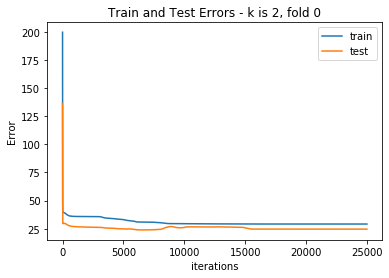

k:  2 ;  fold:  1 ;  cycle:  0
fit residual 9.975274232915947e-10
train residual 29.5088
test residual 22.067

k:  2 ;  fold:  1 ;  cycle:  1
fit residual 9.984249313985972e-10
train residual 29.5088
test residual 22.067

k:  2 ;  fold:  1 ;  cycle:  2
fit residual 9.984346376234148e-10
train residual 29.5088
test residual 22.067

k:  2 ;  fold:  1 ;  cycle:  3
fit residual 9.981129946502325e-10
train residual 29.5088
test residual 22.067

k:  2 ;  fold:  1 ;  cycle:  4
fit residual 9.99497974249057e-10
train residual 29.5088
test residual 22.067



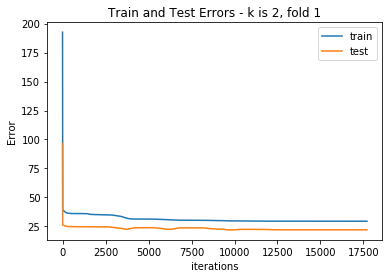

k:  2 ;  fold:  2 ;  cycle:  0
fit residual 1.2461396840196005e-06
train residual 29.1365
test residual 24.7087

k:  2 ;  fold:  2 ;  cycle:  1
fit residual 5.0436084139799846e-05
train residual 29.1294
test residual 24.846

k:  2 ;  fold:  2 ;  cycle:  2
fit residual 2.2039379467589557e-05
train residual 29.1208
test residual 24.7449

k:  2 ;  fold:  2 ;  cycle:  3
fit residual 0.0001214069250199775
train residual 29.1295
test residual 24.8345

k:  2 ;  fold:  2 ;  cycle:  4
fit residual 0.000710592878124035
train residual 29.1878
test residual 24.6005



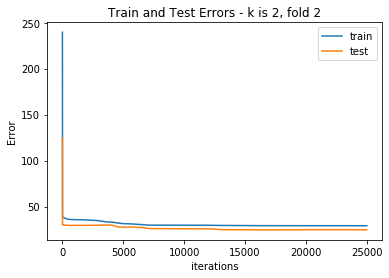

k:  2 ;  fold:  3 ;  cycle:  0
fit residual 7.688162005274949e-05
train residual 29.2663
test residual 22.5835

k:  2 ;  fold:  3 ;  cycle:  1
fit residual 3.846014233346831e-07
train residual 29.2663
test residual 22.5834

k:  2 ;  fold:  3 ;  cycle:  2
fit residual 0.00043755545440349336
train residual 29.2674
test residual 22.5864

k:  2 ;  fold:  3 ;  cycle:  3
fit residual 0.0001163279678298356
train residual 29.2664
test residual 22.5835

k:  2 ;  fold:  3 ;  cycle:  4
fit residual 4.05734351011197e-06
train residual 29.2663
test residual 22.5834



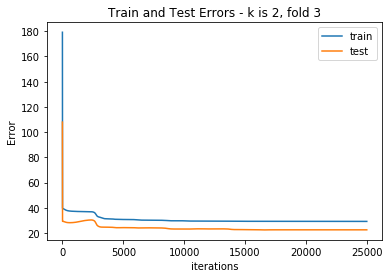

k:  3 ;  fold:  0 ;  cycle:  0
fit residual 0.0001366678920162192
train residual 19.7658
test residual 15.8792

k:  3 ;  fold:  0 ;  cycle:  1
fit residual 0.00010898022225536307
train residual 19.7529
test residual 15.5838

k:  3 ;  fold:  0 ;  cycle:  2
fit residual 8.050790069173703e-05
train residual 19.7358
test residual 15.8111

k:  3 ;  fold:  0 ;  cycle:  3
fit residual 0.0001600084414168304
train residual 19.7034
test residual 15.792

k:  3 ;  fold:  0 ;  cycle:  4
fit residual 2.3905789397791125e-05
train residual 19.7112
test residual 15.4427



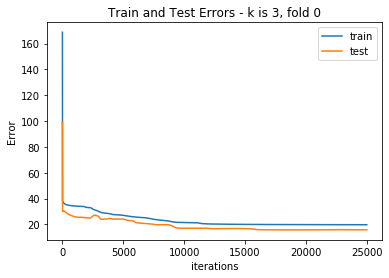

k:  3 ;  fold:  1 ;  cycle:  0
fit residual 0.0002236735449075132
train residual 19.862
test residual 17.1303

k:  3 ;  fold:  1 ;  cycle:  1
fit residual 0.0013346200639832548
train residual 19.7309
test residual 18.0375

k:  3 ;  fold:  1 ;  cycle:  2
fit residual 0.0019086865318111753
train residual 19.7382
test residual 19.0937

k:  3 ;  fold:  1 ;  cycle:  3
fit residual 0.000831609823576554
train residual 19.7725
test residual 18.1744

k:  3 ;  fold:  1 ;  cycle:  4
fit residual 0.0004668302467342009
train residual 19.7609
test residual 17.8936



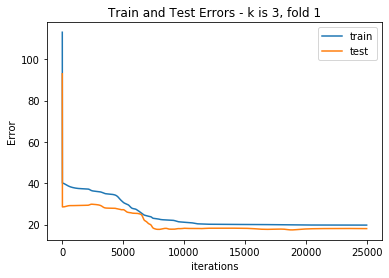

k:  3 ;  fold:  2 ;  cycle:  0
fit residual 1.5615496024387873e-05
train residual 19.8444
test residual 15.782

k:  3 ;  fold:  2 ;  cycle:  1
fit residual 1.3541800125017343e-05
train residual 19.8415
test residual 15.7592

k:  3 ;  fold:  2 ;  cycle:  2
fit residual 0.00025831041037345645
train residual 19.9682
test residual 16.8208

k:  3 ;  fold:  2 ;  cycle:  3
fit residual 0.00046060707404404697
train residual 19.8604
test residual 16.003

k:  3 ;  fold:  2 ;  cycle:  4
fit residual 0.0003891003707425581
train residual 19.8673
test residual 15.9458



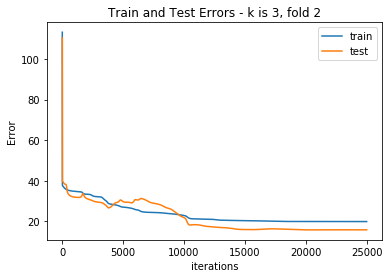

k:  3 ;  fold:  3 ;  cycle:  0
fit residual 8.23007091169238e-05
train residual 20.4473
test residual 18.5401

k:  3 ;  fold:  3 ;  cycle:  1
fit residual 8.993198551496808e-05
train residual 20.4005
test residual 18.1995

k:  3 ;  fold:  3 ;  cycle:  2
fit residual 0.0009440093744916118
train residual 20.4224
test residual 19.4731

k:  3 ;  fold:  3 ;  cycle:  3
fit residual 6.392453486508516e-06
train residual 20.3767
test residual 18.3496

k:  3 ;  fold:  3 ;  cycle:  4
fit residual 1.3335567884233553e-06
train residual 20.3766
test residual 18.351



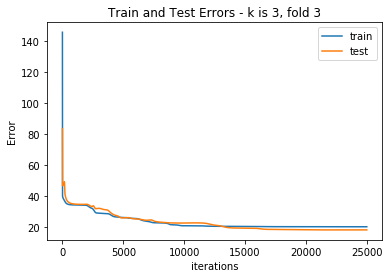

k:  4 ;  fold:  0 ;  cycle:  0
fit residual 0.0007516836769387206
train residual 13.613
test residual 12.5239

k:  4 ;  fold:  0 ;  cycle:  1
fit residual 0.0009030290615023531
train residual 13.3156
test residual 12.2125

k:  4 ;  fold:  0 ;  cycle:  2
fit residual 0.0015305786932200056
train residual 13.0774
test residual 11.8919

k:  4 ;  fold:  0 ;  cycle:  3
fit residual 0.00024063428307923333
train residual 13.2649
test residual 12.4096

k:  4 ;  fold:  0 ;  cycle:  4
fit residual 0.009543941022528412
train residual 14.8272
test residual 16.58



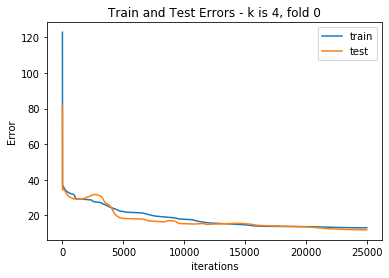

k:  4 ;  fold:  1 ;  cycle:  0
fit residual 0.00012516992115564553
train residual 12.6519
test residual 13.1325

k:  4 ;  fold:  1 ;  cycle:  1
fit residual 0.0054003114964030745
train residual 17.3163
test residual 105.2921

k:  4 ;  fold:  1 ;  cycle:  2
fit residual 0.0011790275522127764
train residual 13.0579
test residual 13.4182

k:  4 ;  fold:  1 ;  cycle:  3
fit residual 0.00014505604584749964
train residual 12.413
test residual 12.971

k:  4 ;  fold:  1 ;  cycle:  4
fit residual 0.0003061522161426147
train residual 12.3847
test residual 13.0609



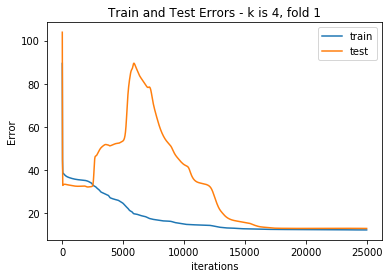

k:  4 ;  fold:  2 ;  cycle:  0
fit residual 0.0006277419182072398
train residual 14.8518
test residual 10.73

k:  4 ;  fold:  2 ;  cycle:  1
fit residual 0.000786371269560147
train residual 14.0976
test residual 10.8874

k:  4 ;  fold:  2 ;  cycle:  2
fit residual 0.00042507700249703957
train residual 15.2053
test residual 10.7544

k:  4 ;  fold:  2 ;  cycle:  3
fit residual 0.0006840388623328131
train residual 13.919
test residual 10.6532

k:  4 ;  fold:  2 ;  cycle:  4
fit residual 0.0010093420423699761
train residual 18.0947
test residual 16.8186



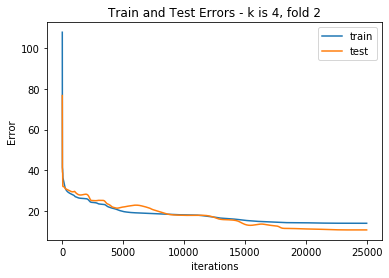

k:  4 ;  fold:  3 ;  cycle:  0
fit residual 0.0004960405340764723
train residual 13.8664
test residual 12.582

k:  4 ;  fold:  3 ;  cycle:  1
fit residual 0.001008919268174211
train residual 13.8253
test residual 11.1778

k:  4 ;  fold:  3 ;  cycle:  2
fit residual 0.0014327141604207423
train residual 13.5976
test residual 12.7335

k:  4 ;  fold:  3 ;  cycle:  3
fit residual 6.0631766536743045e-05
train residual 13.5407
test residual 12.0996

k:  4 ;  fold:  3 ;  cycle:  4
fit residual 0.0011852708789582154
train residual 14.1157
test residual 14.3502



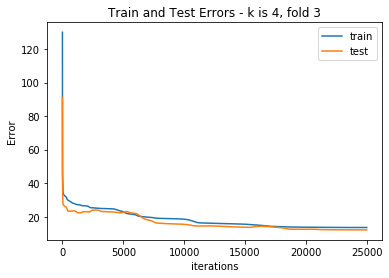

k:  5 ;  fold:  0 ;  cycle:  0
fit residual 0.0010656673143492753
train residual 7.36
test residual 8.0726

k:  5 ;  fold:  0 ;  cycle:  1
fit residual 0.00037780066295075963
train residual 6.4264
test residual 9.1529

k:  5 ;  fold:  0 ;  cycle:  2
fit residual 0.002206501313000023
train residual 11.7601
test residual 18.3136

k:  5 ;  fold:  0 ;  cycle:  3
fit residual 0.0010820154420736437
train residual 6.4246
test residual 7.5343

k:  5 ;  fold:  0 ;  cycle:  4
fit residual 0.0002424075102991742
train residual 7.0422
test residual 8.8757



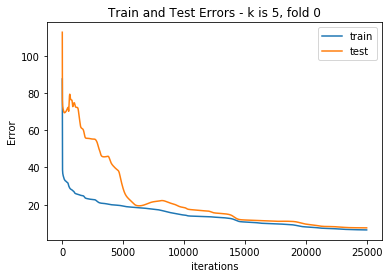

k:  5 ;  fold:  1 ;  cycle:  0
fit residual 0.0009223833714724794
train residual 9.6954
test residual 52.9901

k:  5 ;  fold:  1 ;  cycle:  1
fit residual 0.0011439154747426967
train residual 8.9703
test residual 9.8199

k:  5 ;  fold:  1 ;  cycle:  2
fit residual 0.001618118477215267
train residual 9.5347
test residual 9.6138

k:  5 ;  fold:  1 ;  cycle:  3
fit residual 0.0004843860528243051
train residual 6.9595
test residual 8.3204

k:  5 ;  fold:  1 ;  cycle:  4
fit residual 0.00039517937768970303
train residual 6.3957
test residual 7.356



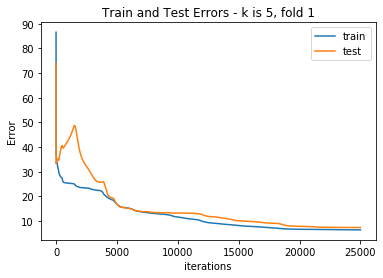

k:  5 ;  fold:  2 ;  cycle:  0
fit residual 0.0028276568035260903
train residual 12.5858
test residual 10.2123

k:  5 ;  fold:  2 ;  cycle:  1
fit residual 0.00020437236422505032
train residual 6.8362
test residual 7.1508

k:  5 ;  fold:  2 ;  cycle:  2
fit residual 0.000590173242696816
train residual 6.5292
test residual 7.4126

k:  5 ;  fold:  2 ;  cycle:  3
fit residual 0.0015323638615255747
train residual 7.1721
test residual 8.0966

k:  5 ;  fold:  2 ;  cycle:  4
fit residual 0.001300165539040587
train residual 8.0844
test residual 9.4269



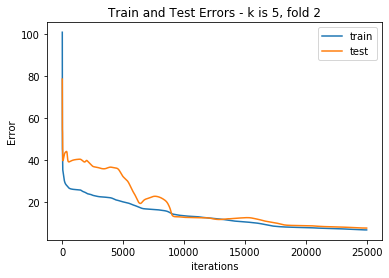

k:  5 ;  fold:  3 ;  cycle:  0
fit residual 0.0011441729188992912
train residual 10.974
test residual 56.5676

k:  5 ;  fold:  3 ;  cycle:  1
fit residual 0.0005041662453598665
train residual 7.5775
test residual 8.4023

k:  5 ;  fold:  3 ;  cycle:  2
fit residual 0.002860112560978604
train residual 6.7406
test residual 7.8402

k:  5 ;  fold:  3 ;  cycle:  3
fit residual 0.00045119129131141833
train residual 6.1798
test residual 7.1596

k:  5 ;  fold:  3 ;  cycle:  4
fit residual 0.00040646440711296155
train residual 6.474
test residual 6.9569



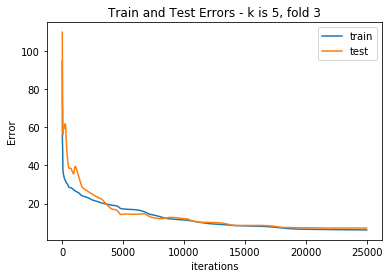

k:  6 ;  fold:  0 ;  cycle:  0
fit residual 0.0006511930479441236
train residual 5.9297
test residual 9.0083

k:  6 ;  fold:  0 ;  cycle:  1
fit residual 0.0007846919675110301
train residual 6.1897
test residual 8.6251

k:  6 ;  fold:  0 ;  cycle:  2
fit residual 0.0002750400942546705
train residual 5.9868
test residual 7.8842

k:  6 ;  fold:  0 ;  cycle:  3
fit residual 0.0007461145552893062
train residual 7.1975
test residual 10.5583

k:  6 ;  fold:  0 ;  cycle:  4
fit residual 0.0003463595380632711
train residual 6.0016
test residual 8.044



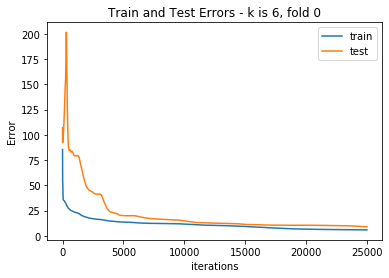

k:  6 ;  fold:  1 ;  cycle:  0
fit residual 0.00037486920569951304
train residual 6.2855
test residual 7.6828

k:  6 ;  fold:  1 ;  cycle:  1
fit residual 0.00067356104147715
train residual 6.6545
test residual 83.3197

k:  6 ;  fold:  1 ;  cycle:  2
fit residual 0.001216285268723355
train residual 6.4661
test residual 22.9201

k:  6 ;  fold:  1 ;  cycle:  3
fit residual 0.0002788333741080004
train residual 6.5277
test residual 8.163

k:  6 ;  fold:  1 ;  cycle:  4
fit residual 0.0009596500598590172
train residual 6.5092
test residual 9.3671



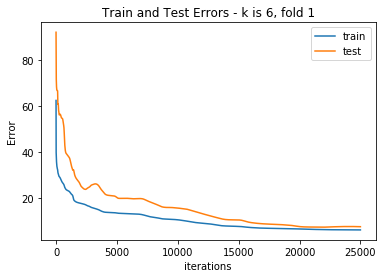

k:  6 ;  fold:  2 ;  cycle:  0
fit residual 0.0009605198256109757
train residual 6.7536
test residual 9.3428

k:  6 ;  fold:  2 ;  cycle:  1
fit residual 0.0009986253657441185
train residual 6.0482
test residual 7.3307

k:  6 ;  fold:  2 ;  cycle:  2
fit residual 0.0009017115990877729
train residual 11.5117
test residual 18225.4894

k:  6 ;  fold:  2 ;  cycle:  3
fit residual 0.0006160639077813991
train residual 5.8552
test residual 9.8174

k:  6 ;  fold:  2 ;  cycle:  4
fit residual 0.0016954140949076437
train residual 6.4519
test residual 61.0241



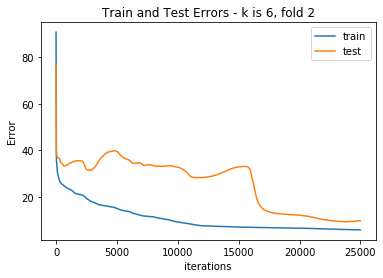

k:  6 ;  fold:  3 ;  cycle:  0
fit residual 0.00031776077379106746
train residual 5.7295
test residual 7.8722

k:  6 ;  fold:  3 ;  cycle:  1
fit residual 0.0004943070573672401
train residual 6.1024
test residual 8.4436

k:  6 ;  fold:  3 ;  cycle:  2
fit residual 0.0008070365054802189
train residual 6.2028
test residual 9.0896

k:  6 ;  fold:  3 ;  cycle:  3
fit residual 0.00037013575740342563
train residual 5.5664
test residual 7.335

k:  6 ;  fold:  3 ;  cycle:  4
fit residual 0.0007258845978135998
train residual 5.7963
test residual 75.0835



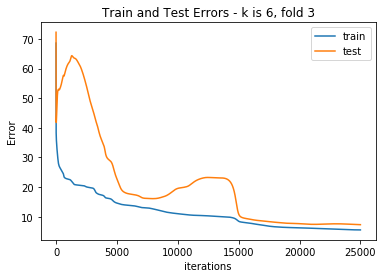

k:  7 ;  fold:  0 ;  cycle:  0
fit residual 0.0002333335869502512
train residual 5.9666
test residual 36.8845

k:  7 ;  fold:  0 ;  cycle:  1
fit residual 0.00022031043876868402
train residual 5.33
test residual 9.0807

k:  7 ;  fold:  0 ;  cycle:  2
fit residual 0.0001155060207260949
train residual 5.4513
test residual 8.6214

k:  7 ;  fold:  0 ;  cycle:  3
fit residual 0.0003350446232022635
train residual 5.7446
test residual 36.018

k:  7 ;  fold:  0 ;  cycle:  4
fit residual 0.0003122719629466589
train residual 5.7584
test residual 10.8469



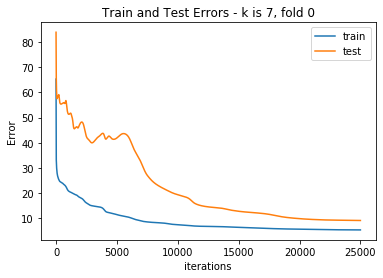

k:  7 ;  fold:  1 ;  cycle:  0
fit residual 0.0003090046528491895
train residual 5.3625
test residual 8.09

k:  7 ;  fold:  1 ;  cycle:  1
fit residual 0.0016740745458032958
train residual 6.6673
test residual 954.1593

k:  7 ;  fold:  1 ;  cycle:  2
fit residual 0.00026739335789161423
train residual 5.34
test residual 7.9098

k:  7 ;  fold:  1 ;  cycle:  3
fit residual 0.00022005712820384016
train residual 5.2337
test residual 8.6141

k:  7 ;  fold:  1 ;  cycle:  4
fit residual 0.00024086738762245635
train residual 5.3299
test residual 7.391



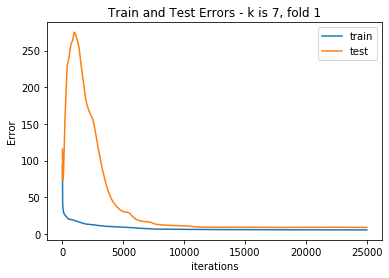

k:  7 ;  fold:  2 ;  cycle:  0
fit residual 0.00028754916102805185
train residual 5.7524
test residual 8.636

k:  7 ;  fold:  2 ;  cycle:  1
fit residual 0.0002586576939306652
train residual 5.4989
test residual 32.83

k:  7 ;  fold:  2 ;  cycle:  2
fit residual 0.0005010880911484509
train residual 6.1639
test residual 35.699

k:  7 ;  fold:  2 ;  cycle:  3
fit residual 0.00018655370518720155
train residual 5.2553
test residual 8.4893

k:  7 ;  fold:  2 ;  cycle:  4
fit residual 0.00017217002848987794
train residual 5.318
test residual 9.2282



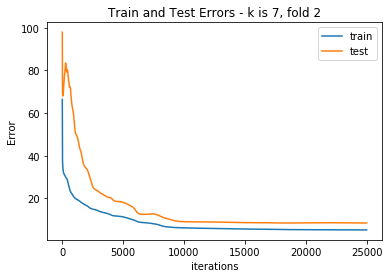

k:  7 ;  fold:  3 ;  cycle:  0
fit residual 0.0001796375455058296
train residual 5.3192
test residual 6.7281

k:  7 ;  fold:  3 ;  cycle:  1
fit residual 0.0001199271672159295
train residual 5.4039
test residual 7.2473

k:  7 ;  fold:  3 ;  cycle:  2
fit residual 0.00010483142023770778
train residual 5.2447
test residual 6.8879

k:  7 ;  fold:  3 ;  cycle:  3
fit residual 0.0001473273592398204
train residual 5.4157
test residual 16.5569

k:  7 ;  fold:  3 ;  cycle:  4
fit residual 0.00013212496749393833
train residual 5.4329
test residual 6.953



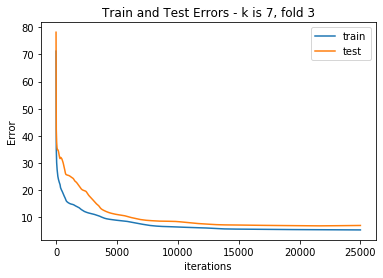

k:  8 ;  fold:  0 ;  cycle:  0
fit residual 0.001143381582436802
train residual 5.2565
test residual 11.6355

k:  8 ;  fold:  0 ;  cycle:  1
fit residual 0.0005013039179250265
train residual 5.9161
test residual 39.4485

k:  8 ;  fold:  0 ;  cycle:  2
fit residual 0.0005648870632556883
train residual 5.1964
test residual 55.1869

k:  8 ;  fold:  0 ;  cycle:  3
fit residual 0.00024258336448273581
train residual 5.279
test residual 9.8603

k:  8 ;  fold:  0 ;  cycle:  4
fit residual 0.00030547337461992276
train residual 5.2748
test residual 15.4443



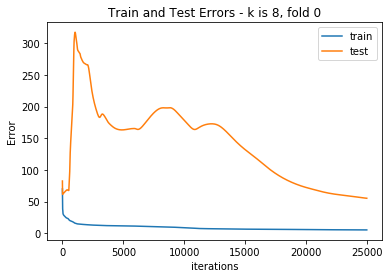

k:  8 ;  fold:  1 ;  cycle:  0
fit residual 0.0002594264135437527
train residual 5.3201
test residual 104.6959

k:  8 ;  fold:  1 ;  cycle:  1
fit residual 0.0003277682337694573
train residual 5.0788
test residual 34.5385

k:  8 ;  fold:  1 ;  cycle:  2
fit residual 0.0002189550211536468
train residual 5.4202
test residual 12.6592

k:  8 ;  fold:  1 ;  cycle:  3
fit residual 0.00022482274896059077
train residual 5.1075
test residual 16.0863

k:  8 ;  fold:  1 ;  cycle:  4
fit residual 0.00042222329078731534
train residual 5.3843
test residual 62.1253



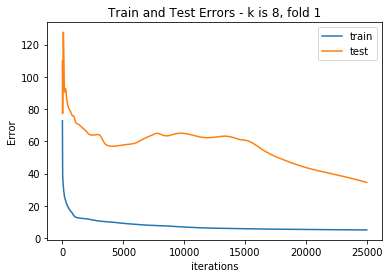

k:  8 ;  fold:  2 ;  cycle:  0
fit residual 0.0002022623964236602
train residual 5.2904
test residual 7.0512

k:  8 ;  fold:  2 ;  cycle:  1
fit residual 0.0005666816771949673
train residual 5.2644
test residual 40.0271

k:  8 ;  fold:  2 ;  cycle:  2
fit residual 0.00010539256331768918
train residual 5.2764
test residual 67.1532

k:  8 ;  fold:  2 ;  cycle:  3
fit residual 0.000674534842584645
train residual 5.621
test residual 7.8854

k:  8 ;  fold:  2 ;  cycle:  4
fit residual 8.788856220080943e-05
train residual 5.2089
test residual 61.2947



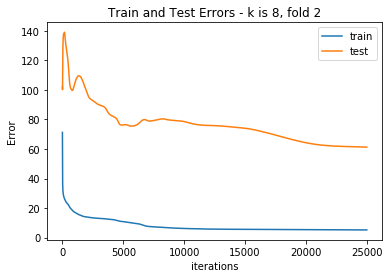

k:  8 ;  fold:  3 ;  cycle:  0
fit residual 0.0002843438804507467
train residual 5.3041
test residual 12.7457

k:  8 ;  fold:  3 ;  cycle:  1
fit residual 0.0002451966388780132
train residual 5.1314
test residual 7.2411

k:  8 ;  fold:  3 ;  cycle:  2
fit residual 8.475943680966047e-05
train residual 4.789
test residual 11.2976

k:  8 ;  fold:  3 ;  cycle:  3
fit residual 0.0004922269984179541
train residual 5.5923
test residual 11.1161

k:  8 ;  fold:  3 ;  cycle:  4
fit residual 0.00017715289795849969
train residual 4.882
test residual 11.5887



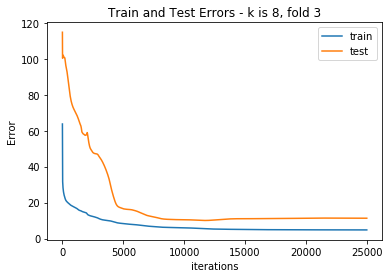

k:  9 ;  fold:  0 ;  cycle:  0
fit residual 0.00019019451393304258
train residual 5.2808
test residual 10.6127

k:  9 ;  fold:  0 ;  cycle:  1
fit residual 0.00010532741875017697
train residual 4.6179
test residual 190.4512

k:  9 ;  fold:  0 ;  cycle:  2
fit residual 0.00017953906295884193
train residual 5.0535
test residual 1591.4648

k:  9 ;  fold:  0 ;  cycle:  3
fit residual 9.369648167674247e-05
train residual 4.7645
test residual 9.7335

k:  9 ;  fold:  0 ;  cycle:  4
fit residual 0.0002456103626633064
train residual 4.8162
test residual 13.4922



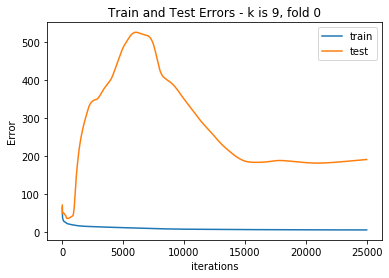

k:  9 ;  fold:  1 ;  cycle:  0
fit residual 0.00010981700699799182
train residual 4.9598
test residual 114.1197

k:  9 ;  fold:  1 ;  cycle:  1
fit residual 0.00030806227578030273
train residual 4.936
test residual 48.7781

k:  9 ;  fold:  1 ;  cycle:  2
fit residual 0.0001756815495520284
train residual 4.7496
test residual 12.3594

k:  9 ;  fold:  1 ;  cycle:  3
fit residual 0.00022799029021405227
train residual 4.9373
test residual 17.5424

k:  9 ;  fold:  1 ;  cycle:  4
fit residual 0.00016747332700897536
train residual 4.7562
test residual 15.9817



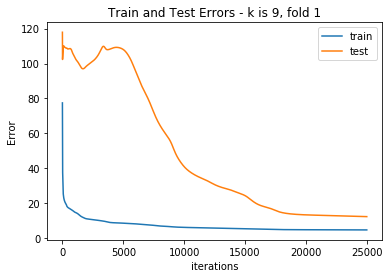

k:  9 ;  fold:  2 ;  cycle:  0
fit residual 0.00017092529586049495
train residual 4.8941
test residual 29.9505

k:  9 ;  fold:  2 ;  cycle:  1
fit residual 0.00011473391009917266
train residual 4.7937
test residual 11.7843

k:  9 ;  fold:  2 ;  cycle:  2
fit residual 0.00016463471180416488
train residual 4.8119
test residual 798.1178

k:  9 ;  fold:  2 ;  cycle:  3
fit residual 0.0001462718027344304
train residual 4.896
test residual 10.513

k:  9 ;  fold:  2 ;  cycle:  4
fit residual 0.00013800021852460956
train residual 4.6961
test residual 24.6308



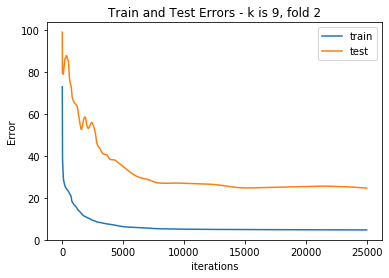

k:  9 ;  fold:  3 ;  cycle:  0
fit residual 0.00012048237318369962
train residual 4.7215
test residual 18.7775

k:  9 ;  fold:  3 ;  cycle:  1
fit residual 7.499497109132609e-05
train residual 4.5668
test residual 169.5511

k:  9 ;  fold:  3 ;  cycle:  2
fit residual 0.00014694631299448253
train residual 4.8258
test residual 7.4247

k:  9 ;  fold:  3 ;  cycle:  3
fit residual 5.0547115374433635e-05
train residual 4.6348
test residual 7.7958

k:  9 ;  fold:  3 ;  cycle:  4
fit residual 0.00011598893787006534
train residual 4.7081
test residual 26.0572



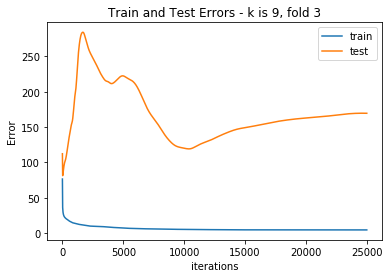

k:  10 ;  fold:  0 ;  cycle:  0
fit residual 0.00012219119833566846
train residual 4.6974
test residual 788.647

k:  10 ;  fold:  0 ;  cycle:  1
fit residual 5.754004454237531e-05
train residual 4.5744
test residual 22.4806

k:  10 ;  fold:  0 ;  cycle:  2
fit residual 0.00020084190795033327
train residual 4.4831
test residual 53.4746

k:  10 ;  fold:  0 ;  cycle:  3
fit residual 0.00025353169558026215
train residual 4.4008
test residual 104.8409

k:  10 ;  fold:  0 ;  cycle:  4
fit residual 0.00012736736878382886
train residual 4.5604
test residual 49.2619



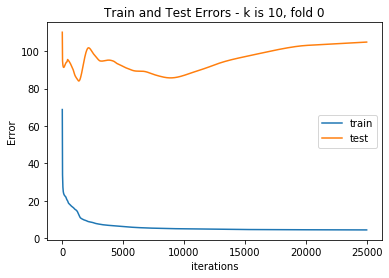

k:  10 ;  fold:  1 ;  cycle:  0
fit residual 0.00010147818562587587
train residual 4.4407
test residual 51.2042

k:  10 ;  fold:  1 ;  cycle:  1
fit residual 7.878217566493628e-05
train residual 4.2544
test residual 251209.0306

k:  10 ;  fold:  1 ;  cycle:  2
fit residual 5.519892656870655e-05
train residual 4.3284
test residual 25.2701

k:  10 ;  fold:  1 ;  cycle:  3
fit residual 0.00012344507714830052
train residual 4.2971
test residual 39.0239

k:  10 ;  fold:  1 ;  cycle:  4
fit residual 4.877090413848435e-05
train residual 4.4277
test residual 55.5945



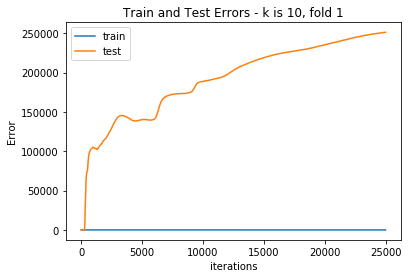

k:  10 ;  fold:  2 ;  cycle:  0
fit residual 9.743107888981726e-05
train residual 4.4547
test residual 62.015

k:  10 ;  fold:  2 ;  cycle:  1
fit residual 6.307898990524523e-05
train residual 4.3136
test residual 116.0708

k:  10 ;  fold:  2 ;  cycle:  2
fit residual 0.0001561544085785744
train residual 4.4465
test residual 45.9141

k:  10 ;  fold:  2 ;  cycle:  3
fit residual 0.00034668458128526866
train residual 4.6474
test residual 216.1939

k:  10 ;  fold:  2 ;  cycle:  4
fit residual 0.00016917230032503826
train residual 4.5725
test residual 50.748



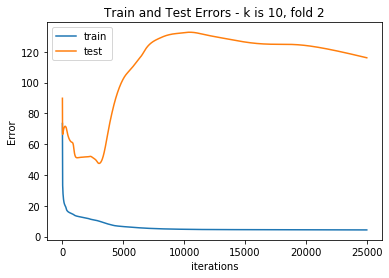

k:  10 ;  fold:  3 ;  cycle:  0
fit residual 4.458952595342847e-05
train residual 4.7701
test residual 82.8251

k:  10 ;  fold:  3 ;  cycle:  1
fit residual 0.00010523018181341753
train residual 4.5525
test residual 250.8561

k:  10 ;  fold:  3 ;  cycle:  2
fit residual 9.832144426154628e-05
train residual 4.501
test residual 112.439

k:  10 ;  fold:  3 ;  cycle:  3
fit residual 6.545630549729085e-05
train residual 4.3211
test residual 17.054

k:  10 ;  fold:  3 ;  cycle:  4
fit residual 7.006669939426485e-05
train residual 4.4437
test residual 105.427



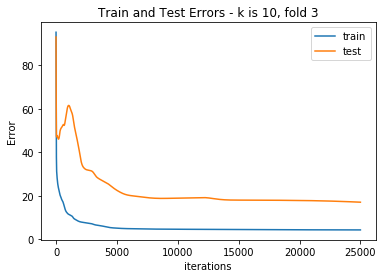

k:  11 ;  fold:  0 ;  cycle:  0
fit residual 7.9634236618485e-05
train residual 4.3095
test residual 68.2645

k:  11 ;  fold:  0 ;  cycle:  1
fit residual 0.00021873686061573593
train residual 4.3095
test residual 26.2879

k:  11 ;  fold:  0 ;  cycle:  2
fit residual 9.614267289725438e-05
train residual 4.2047
test residual 148.3262

k:  11 ;  fold:  0 ;  cycle:  3
fit residual 0.00010505610927080893
train residual 4.2029
test residual 25.5429

k:  11 ;  fold:  0 ;  cycle:  4
fit residual 7.088732917376347e-05
train residual 3.9514
test residual 70.0047



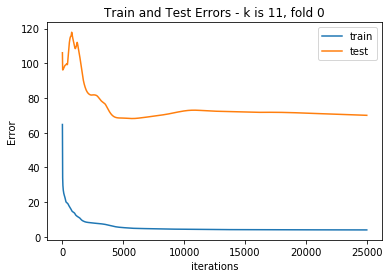

k:  11 ;  fold:  1 ;  cycle:  0
fit residual 0.00010951386731473897
train residual 4.0207
test residual 23.7426

k:  11 ;  fold:  1 ;  cycle:  1
fit residual 8.187300314487731e-05
train residual 3.988
test residual 52.6423

k:  11 ;  fold:  1 ;  cycle:  2
fit residual 5.135584446632648e-05
train residual 4.1506
test residual 179.4062

k:  11 ;  fold:  1 ;  cycle:  3
fit residual 9.36488421031564e-05
train residual 3.9315
test residual 49.2644

k:  11 ;  fold:  1 ;  cycle:  4
fit residual 0.00010606399548952723
train residual 4.2437
test residual 72.6476



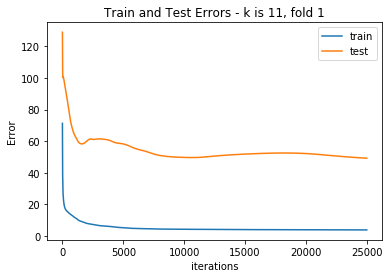

k:  11 ;  fold:  2 ;  cycle:  0
fit residual 0.00020771373597684674
train residual 3.9785
test residual 28.9491

k:  11 ;  fold:  2 ;  cycle:  1
fit residual 0.00010412794952996545
train residual 4.2547
test residual 71.0271

k:  11 ;  fold:  2 ;  cycle:  2
fit residual 9.57385129999675e-05
train residual 4.2873
test residual 55.7578

k:  11 ;  fold:  2 ;  cycle:  3
fit residual 0.0001131222884597571
train residual 3.8932
test residual 78.5761

k:  11 ;  fold:  2 ;  cycle:  4
fit residual 8.977844636740074e-05
train residual 3.9918
test residual 56.5849



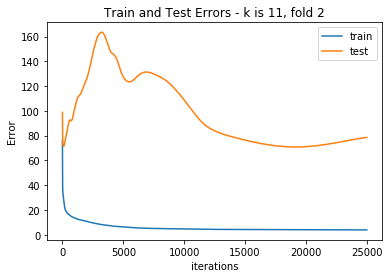

k:  11 ;  fold:  3 ;  cycle:  0
fit residual 5.664798207318414e-05
train residual 4.1226
test residual 66.8118

k:  11 ;  fold:  3 ;  cycle:  1
fit residual 7.172060255445621e-05
train residual 4.4311
test residual 50.1662

k:  11 ;  fold:  3 ;  cycle:  2
fit residual 0.0001548378494531673
train residual 4.0734
test residual 164.4622

k:  11 ;  fold:  3 ;  cycle:  3
fit residual 0.00012199191139952667
train residual 3.8008
test residual 176.6298

k:  11 ;  fold:  3 ;  cycle:  4
fit residual 0.00011225932332158464
train residual 3.8095
test residual 84.298



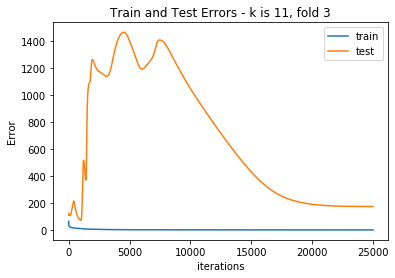

k:  12 ;  fold:  0 ;  cycle:  0
fit residual 7.644327493554375e-05
train residual 3.4346
test residual 73.3349

k:  12 ;  fold:  0 ;  cycle:  1
fit residual 0.0001635303558224157
train residual 3.7366
test residual 19.1022

k:  12 ;  fold:  0 ;  cycle:  2
fit residual 0.00014341288690277777
train residual 3.5186
test residual 139.3737

k:  12 ;  fold:  0 ;  cycle:  3
fit residual 0.00013154742667466056
train residual 4.3351
test residual 2745718.5263

k:  12 ;  fold:  0 ;  cycle:  4
fit residual 9.323623098982345e-05
train residual 3.533
test residual 95.3644



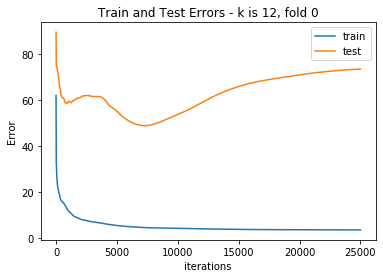

k:  12 ;  fold:  1 ;  cycle:  0
fit residual 0.0001600931510535674
train residual 3.3337
test residual 50.6494

k:  12 ;  fold:  1 ;  cycle:  1
fit residual 8.271155278011343e-05
train residual 3.9168
test residual 173.2443

k:  12 ;  fold:  1 ;  cycle:  2
fit residual 0.00012111565326355169
train residual 3.5896
test residual 1506.1139

k:  12 ;  fold:  1 ;  cycle:  3
fit residual 0.00019707366055997952
train residual 3.6892
test residual 98.1855

k:  12 ;  fold:  1 ;  cycle:  4
fit residual 9.837023594474384e-05
train residual 3.8497
test residual 70.0127



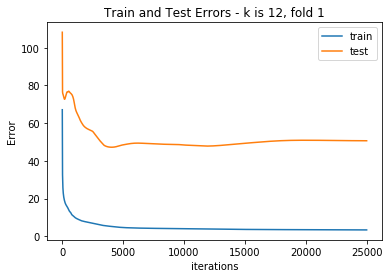

k:  12 ;  fold:  2 ;  cycle:  0
fit residual 0.0001263642092319872
train residual 3.6593
test residual 104.7782

k:  12 ;  fold:  2 ;  cycle:  1
fit residual 9.335600173339021e-05
train residual 3.6972
test residual 91.9328

k:  12 ;  fold:  2 ;  cycle:  2
fit residual 6.716841483924727e-05
train residual 3.9156
test residual 57.5768

k:  12 ;  fold:  2 ;  cycle:  3
fit residual 8.484042346021373e-05
train residual 3.6852
test residual 36.2101

k:  12 ;  fold:  2 ;  cycle:  4
fit residual 0.00017360588754797868
train residual 3.9498
test residual 81.1347



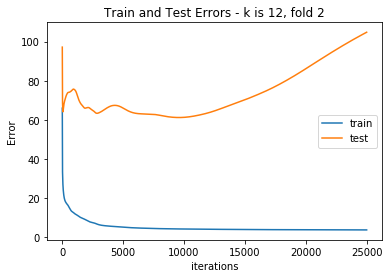

k:  12 ;  fold:  3 ;  cycle:  0
fit residual 0.00012837816260040638
train residual 3.6354
test residual 1566722.8869

k:  12 ;  fold:  3 ;  cycle:  1
fit residual 7.832499357527986e-05
train residual 3.4562
test residual 54.3385

k:  12 ;  fold:  3 ;  cycle:  2
fit residual 0.00013371940671643405
train residual 3.7485
test residual 127.1887

k:  12 ;  fold:  3 ;  cycle:  3
fit residual 6.776488890028862e-05
train residual 3.7891
test residual 2220.8071

k:  12 ;  fold:  3 ;  cycle:  4
fit residual 0.0001798131956370142
train residual 3.4313
test residual 59.7048



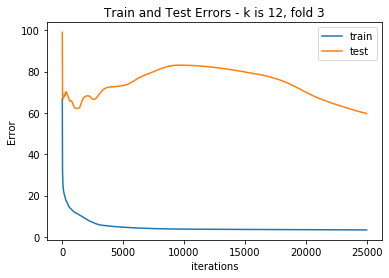

k:  13 ;  fold:  0 ;  cycle:  0
fit residual 0.0002473466899227328
train residual 3.6716
test residual 107.2207

k:  13 ;  fold:  0 ;  cycle:  1
fit residual 6.875796667650822e-05
train residual 3.7409
test residual 1979.449

k:  13 ;  fold:  0 ;  cycle:  2
fit residual 0.00026538789836891605
train residual 3.6477
test residual 4258764.6371

k:  13 ;  fold:  0 ;  cycle:  3
fit residual 0.00018471302478961408
train residual 3.0617
test residual 75.6258

k:  13 ;  fold:  0 ;  cycle:  4
fit residual 7.332217958745713e-05
train residual 3.364
test residual 52.467



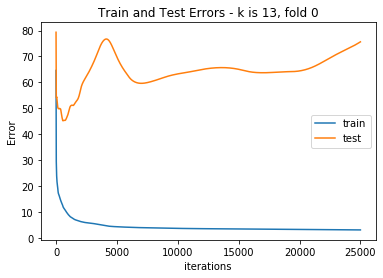

k:  13 ;  fold:  1 ;  cycle:  0
fit residual 0.00023970685376843134
train residual 3.5745
test residual 116.9396

k:  13 ;  fold:  1 ;  cycle:  1
fit residual 0.00015480205396133505
train residual 3.2334
test residual 67.665

k:  13 ;  fold:  1 ;  cycle:  2
fit residual 9.407433413071785e-05
train residual 3.5172
test residual 58.5906

k:  13 ;  fold:  1 ;  cycle:  3
fit residual 0.00010776953323538322
train residual 3.8193
test residual 188002.6151

k:  13 ;  fold:  1 ;  cycle:  4
fit residual 9.904666167631595e-05
train residual 2.9165
test residual 109.2037



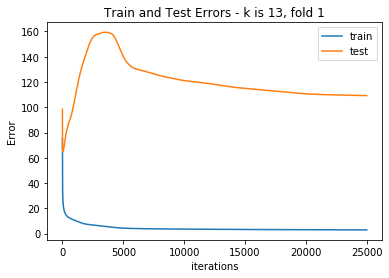

k:  13 ;  fold:  2 ;  cycle:  0
fit residual 0.00012939906176821908
train residual 3.569
test residual 1383.3904

k:  13 ;  fold:  2 ;  cycle:  1
fit residual 6.714576005127078e-05
train residual 3.4606
test residual 114.5764

k:  13 ;  fold:  2 ;  cycle:  2
fit residual 5.804715964985074e-05
train residual 3.6813
test residual 86.9218

k:  13 ;  fold:  2 ;  cycle:  3
fit residual 7.52215028092758e-05
train residual 3.2602
test residual 504.0425

k:  13 ;  fold:  2 ;  cycle:  4
fit residual 0.00011814925416768338
train residual 3.8646
test residual 62.5974



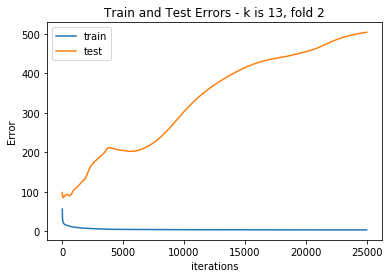

k:  13 ;  fold:  3 ;  cycle:  0
fit residual 6.505809599864755e-05
train residual 3.0509
test residual 148.3481

k:  13 ;  fold:  3 ;  cycle:  1
fit residual 8.751107312893437e-05
train residual 3.2807
test residual 21.6615

k:  13 ;  fold:  3 ;  cycle:  2
fit residual 0.00013077486897653383
train residual 3.6848
test residual 430.5532

k:  13 ;  fold:  3 ;  cycle:  3
fit residual 0.00010220989196627124
train residual 3.0895
test residual 68.4168

k:  13 ;  fold:  3 ;  cycle:  4
fit residual 9.730407476980878e-05
train residual 3.4126
test residual 1304.8436



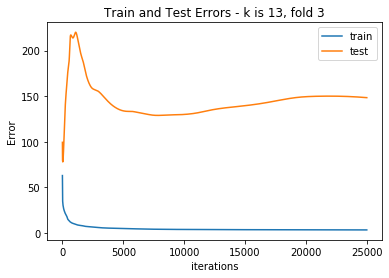

k:  14 ;  fold:  0 ;  cycle:  0
fit residual 0.00014235077263278782
train residual 3.2382
test residual 73.5108

k:  14 ;  fold:  0 ;  cycle:  1
fit residual 0.00012177258040821208
train residual 3.2753
test residual 2169.7965

k:  14 ;  fold:  0 ;  cycle:  2
fit residual 9.663866424502269e-05
train residual 3.1501
test residual 141.4398

k:  14 ;  fold:  0 ;  cycle:  3
fit residual 6.228322235566874e-05
train residual 2.9047
test residual 84.8381

k:  14 ;  fold:  0 ;  cycle:  4
fit residual 9.916286070442048e-05
train residual 3.0972
test residual 76.8846



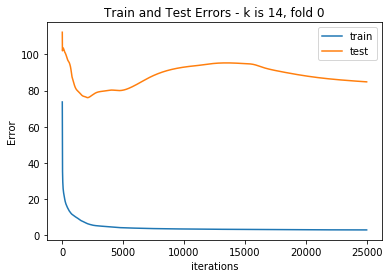

k:  14 ;  fold:  1 ;  cycle:  0
fit residual 0.00012525030620019355
train residual 2.9801
test residual 38.8913

k:  14 ;  fold:  1 ;  cycle:  1
fit residual 0.00011176078674425805
train residual 3.1514
test residual 96.3955

k:  14 ;  fold:  1 ;  cycle:  2
fit residual 6.343993793756579e-05
train residual 2.8899
test residual 66.4107

k:  14 ;  fold:  1 ;  cycle:  3
fit residual 0.00010190200929833584
train residual 2.7998
test residual 96.7229

k:  14 ;  fold:  1 ;  cycle:  4
fit residual 0.00011221447441093455
train residual 2.9455
test residual 7393.5106



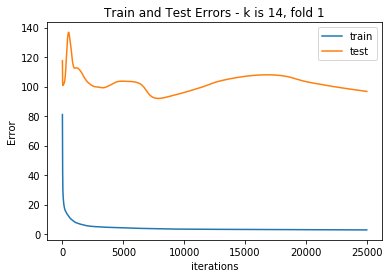

k:  14 ;  fold:  2 ;  cycle:  0
fit residual 5.658308231681299e-05
train residual 3.0341
test residual 113.4718

k:  14 ;  fold:  2 ;  cycle:  1
fit residual 9.728447707024213e-05
train residual 3.379
test residual 62.6608

k:  14 ;  fold:  2 ;  cycle:  2
fit residual 0.00022780903288232107
train residual 2.8448
test residual 223.3549

k:  14 ;  fold:  2 ;  cycle:  3
fit residual 8.057677703780293e-05
train residual 3.0155
test residual 48.9958

k:  14 ;  fold:  2 ;  cycle:  4
fit residual 4.724106658503599e-05
train residual 3.1716
test residual 55.8365



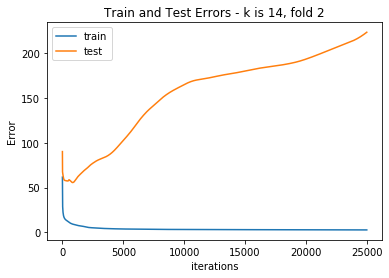

k:  14 ;  fold:  3 ;  cycle:  0
fit residual 9.259698741280623e-05
train residual 2.6249
test residual 40.3043

k:  14 ;  fold:  3 ;  cycle:  1
fit residual 8.633185658760915e-05
train residual 2.9079
test residual 255.5056

k:  14 ;  fold:  3 ;  cycle:  2
fit residual 0.00017504141699793767
train residual 2.9042
test residual 77.9612

k:  14 ;  fold:  3 ;  cycle:  3
fit residual 5.522819164084394e-05
train residual 2.7829
test residual 1790220.3608

k:  14 ;  fold:  3 ;  cycle:  4
fit residual 0.00024755596405806607
train residual 2.8742
test residual 113.8943



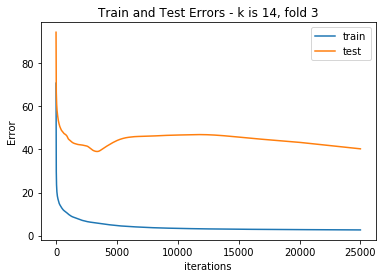

k:  15 ;  fold:  0 ;  cycle:  0
fit residual 8.358027152940719e-05
train residual 2.7808
test residual 74.5294

k:  15 ;  fold:  0 ;  cycle:  1
fit residual 0.00016391302799144303
train residual 3.0092
test residual 46.0037

k:  15 ;  fold:  0 ;  cycle:  2
fit residual 6.526736344551049e-05
train residual 2.4213
test residual 628.794

k:  15 ;  fold:  0 ;  cycle:  3
fit residual 8.898351458450298e-05
train residual 2.7523
test residual 53.8102

k:  15 ;  fold:  0 ;  cycle:  4
fit residual 9.35813552120019e-05
train residual 2.3857
test residual 39.8783



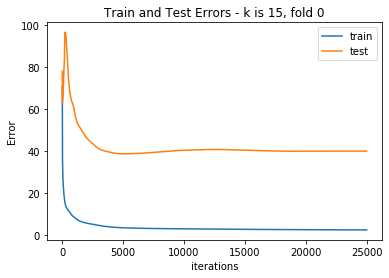

k:  15 ;  fold:  1 ;  cycle:  0
fit residual 0.00011425057150725367
train residual 2.6535
test residual 87.293

k:  15 ;  fold:  1 ;  cycle:  1
fit residual 9.098392239578156e-05
train residual 2.2081
test residual 243.6207

k:  15 ;  fold:  1 ;  cycle:  2
fit residual 9.527515191704184e-05
train residual 2.3184
test residual 50.2102

k:  15 ;  fold:  1 ;  cycle:  3
fit residual 0.00015517552228560636
train residual 2.275
test residual 65.9957

k:  15 ;  fold:  1 ;  cycle:  4
fit residual 7.819597543762215e-05
train residual 2.5502
test residual 1211643.6163



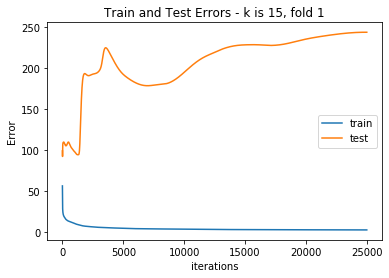

k:  15 ;  fold:  2 ;  cycle:  0
fit residual 9.911175998611462e-05
train residual 2.67
test residual 111.5099

k:  15 ;  fold:  2 ;  cycle:  1
fit residual 9.470152920567817e-05
train residual 2.6049
test residual 91.2061

k:  15 ;  fold:  2 ;  cycle:  2
fit residual 0.00014758892560309532
train residual 2.879
test residual 58.4225

k:  15 ;  fold:  2 ;  cycle:  3
fit residual 9.290917255862098e-05
train residual 2.6838
test residual 128.6062

k:  15 ;  fold:  2 ;  cycle:  4
fit residual 0.00010811254811255403
train residual 2.4999
test residual 55.1546



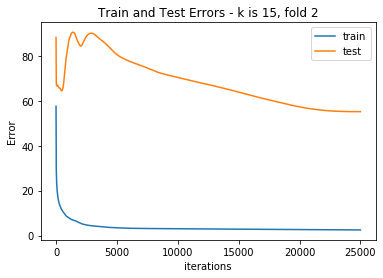

k:  15 ;  fold:  3 ;  cycle:  0
fit residual 8.579550633603397e-05
train residual 2.1608
test residual 57.8341

k:  15 ;  fold:  3 ;  cycle:  1
fit residual 9.958386845129085e-05
train residual 2.6821
test residual 55.2774

k:  15 ;  fold:  3 ;  cycle:  2
fit residual 0.0001084032079613768
train residual 2.5998
test residual 303621.3096

k:  15 ;  fold:  3 ;  cycle:  3
fit residual 0.00012705409689711499
train residual 2.2554
test residual 46.1875

k:  15 ;  fold:  3 ;  cycle:  4
fit residual 0.00011540893318304871
train residual 2.812
test residual 435.0272



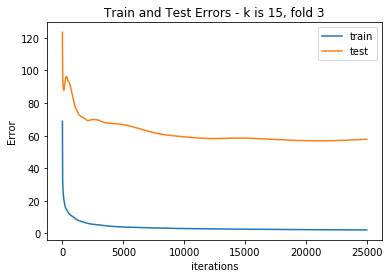

k:  16 ;  fold:  0 ;  cycle:  0
fit residual 8.230662833917317e-05
train residual 2.5907
test residual 79.2434

k:  16 ;  fold:  0 ;  cycle:  1
fit residual 9.903600242159501e-05
train residual 2.1598
test residual 59.7017

k:  16 ;  fold:  0 ;  cycle:  2
fit residual 7.757556297291362e-05
train residual 2.0614
test residual 48.9927

k:  16 ;  fold:  0 ;  cycle:  3
fit residual 0.00010507631874625562
train residual 2.3252
test residual 81.9342

k:  16 ;  fold:  0 ;  cycle:  4
fit residual 7.156651424864967e-05
train residual 2.3102
test residual 83.3059



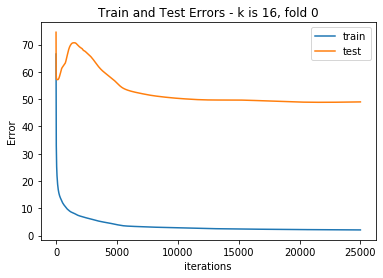

k:  16 ;  fold:  1 ;  cycle:  0
fit residual 9.354911316524896e-05
train residual 2.3551
test residual 95.1481

k:  16 ;  fold:  1 ;  cycle:  1
fit residual 7.939273081056278e-05
train residual 2.1634
test residual 159.2145

k:  16 ;  fold:  1 ;  cycle:  2
fit residual 0.00010585443093081492
train residual 1.8394
test residual 124.7424

k:  16 ;  fold:  1 ;  cycle:  3
fit residual 0.00011364789102372363
train residual 1.7894
test residual 173.8386

k:  16 ;  fold:  1 ;  cycle:  4
fit residual 0.00010930815699307917
train residual 2.1443
test residual 125.0864



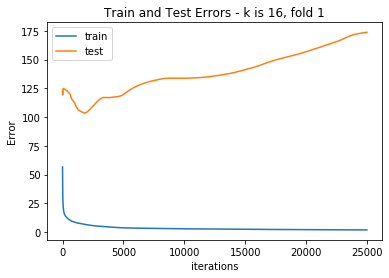

k:  16 ;  fold:  2 ;  cycle:  0
fit residual 9.178666745485112e-05
train residual 2.2405
test residual 570.4424

k:  16 ;  fold:  2 ;  cycle:  1
fit residual 8.172311737237368e-05
train residual 2.3698
test residual 87.1004

k:  16 ;  fold:  2 ;  cycle:  2
fit residual 7.06332763597605e-05
train residual 2.4232
test residual 154.5682

k:  16 ;  fold:  2 ;  cycle:  3
fit residual 0.00016906992192509002
train residual 2.531
test residual 78.0651

k:  16 ;  fold:  2 ;  cycle:  4
fit residual 9.469704495684172e-05
train residual 2.5335
test residual 71.2469



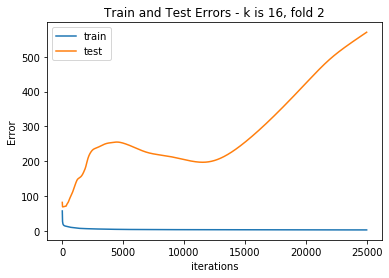

k:  16 ;  fold:  3 ;  cycle:  0
fit residual 7.767389191123534e-05
train residual 2.1574
test residual 97.8191

k:  16 ;  fold:  3 ;  cycle:  1
fit residual 0.00010589702200943713
train residual 2.2796
test residual 60.0482

k:  16 ;  fold:  3 ;  cycle:  2
fit residual 8.839395114518072e-05
train residual 2.0604
test residual 152.7006

k:  16 ;  fold:  3 ;  cycle:  3
fit residual 0.00010950876906040722
train residual 2.4826
test residual 107.8699

k:  16 ;  fold:  3 ;  cycle:  4
fit residual 0.00013047016887124616
train residual 2.1361
test residual 77.0789



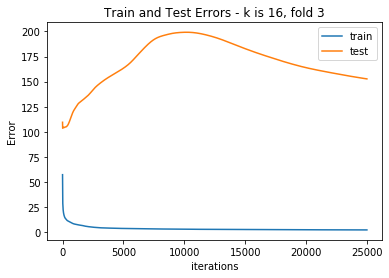

k:  17 ;  fold:  0 ;  cycle:  0
fit residual 8.521050506064847e-05
train residual 2.2605
test residual 60.3369

k:  17 ;  fold:  0 ;  cycle:  1
fit residual 7.558710283768519e-05
train residual 2.157
test residual 66.4382

k:  17 ;  fold:  0 ;  cycle:  2
fit residual 6.509921550702357e-05
train residual 2.1598
test residual 740862.4128

k:  17 ;  fold:  0 ;  cycle:  3
fit residual 8.804205012356999e-05
train residual 2.1721
test residual 116.964

k:  17 ;  fold:  0 ;  cycle:  4
fit residual 6.289269505054726e-05
train residual 2.0735
test residual 214233.3605



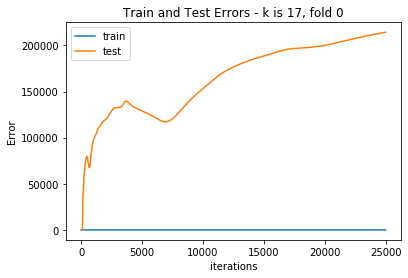

k:  17 ;  fold:  1 ;  cycle:  0
fit residual 9.515523377101132e-05
train residual 1.9628
test residual 322.3377

k:  17 ;  fold:  1 ;  cycle:  1
fit residual 9.149014000745858e-05
train residual 2.0003
test residual 116.8288

k:  17 ;  fold:  1 ;  cycle:  2
fit residual 0.0001094241326493064
train residual 1.9949
test residual 95.1072

k:  17 ;  fold:  1 ;  cycle:  3
fit residual 9.438885080290995e-05
train residual 1.5948
test residual 60.8683

k:  17 ;  fold:  1 ;  cycle:  4
fit residual 9.126031199629098e-05
train residual 1.6364
test residual 152.6924



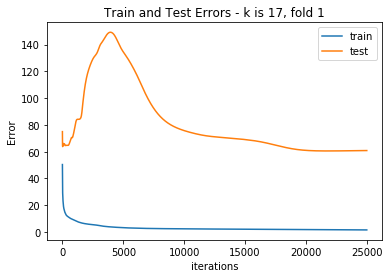

k:  17 ;  fold:  2 ;  cycle:  0
fit residual 0.00012624911664250866
train residual 2.0473
test residual 153.609

k:  17 ;  fold:  2 ;  cycle:  1
fit residual 0.00011534713010302184
train residual 2.301
test residual 810822.4067

k:  17 ;  fold:  2 ;  cycle:  2
fit residual 0.00011138609651572931
train residual 2.1746
test residual 54.6714

k:  17 ;  fold:  2 ;  cycle:  3
fit residual 5.600806509371698e-05
train residual 2.1559
test residual 973629.1709

k:  17 ;  fold:  2 ;  cycle:  4
fit residual 9.12620656237237e-05
train residual 1.8368
test residual 42.7752



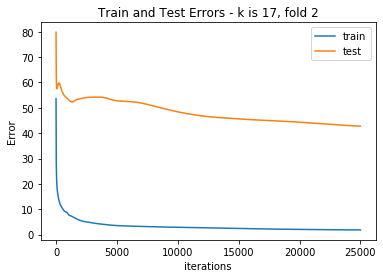

k:  17 ;  fold:  3 ;  cycle:  0
fit residual 0.00011468683924679643
train residual 2.1151
test residual 73.7099

k:  17 ;  fold:  3 ;  cycle:  1
fit residual 0.00013615082281970552
train residual 2.2688
test residual 111.7754

k:  17 ;  fold:  3 ;  cycle:  2
fit residual 8.237123075226041e-05
train residual 2.1089
test residual 72.2716

k:  17 ;  fold:  3 ;  cycle:  3
fit residual 0.00010927723922491123
train residual 1.5527
test residual 71.9214

k:  17 ;  fold:  3 ;  cycle:  4
fit residual 8.079536332793347e-05
train residual 1.9689
test residual 103.0554



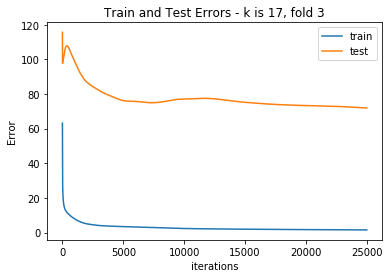

k:  18 ;  fold:  0 ;  cycle:  0
fit residual 6.496878147186602e-05
train residual 1.7581
test residual 57.3569

k:  18 ;  fold:  0 ;  cycle:  1
fit residual 7.477725986349973e-05
train residual 1.9782
test residual 118.4777

k:  18 ;  fold:  0 ;  cycle:  2
fit residual 8.635911450180035e-05
train residual 1.8003
test residual 54.6879

k:  18 ;  fold:  0 ;  cycle:  3
fit residual 8.428223148615532e-05
train residual 1.7042
test residual 46.722

k:  18 ;  fold:  0 ;  cycle:  4
fit residual 6.060241444421748e-05
train residual 1.9287
test residual 65.6474



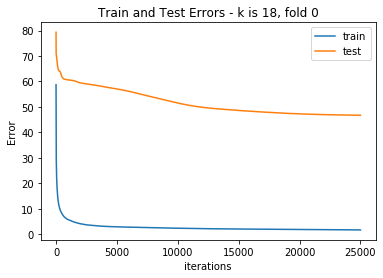

k:  18 ;  fold:  1 ;  cycle:  0
fit residual 0.00010644151453944877
train residual 1.8306
test residual 296412.3219

k:  18 ;  fold:  1 ;  cycle:  1
fit residual 5.356535344905598e-05
train residual 1.2829
test residual 97.7688

k:  18 ;  fold:  1 ;  cycle:  2
fit residual 8.322384775649873e-05
train residual 1.817
test residual 100.6913

k:  18 ;  fold:  1 ;  cycle:  3
fit residual 7.85107171601963e-05
train residual 1.7372
test residual 132322.916

k:  18 ;  fold:  1 ;  cycle:  4
fit residual 9.94988608958376e-05
train residual 1.472
test residual 281.778



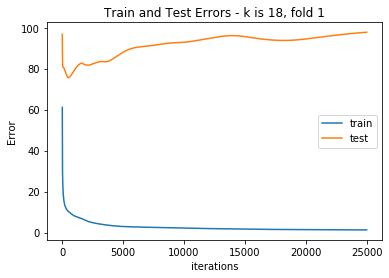

k:  18 ;  fold:  2 ;  cycle:  0
fit residual 6.589219646354651e-05
train residual 1.909
test residual 65.457

k:  18 ;  fold:  2 ;  cycle:  1
fit residual 8.548880853570924e-05
train residual 1.8247
test residual 180.8879

k:  18 ;  fold:  2 ;  cycle:  2
fit residual 7.196775642597273e-05
train residual 1.856
test residual 89.019

k:  18 ;  fold:  2 ;  cycle:  3
fit residual 6.820991534462987e-05
train residual 1.898
test residual 1020251.1058

k:  18 ;  fold:  2 ;  cycle:  4
fit residual 0.00010741374276536721
train residual 1.6753
test residual 73.5123



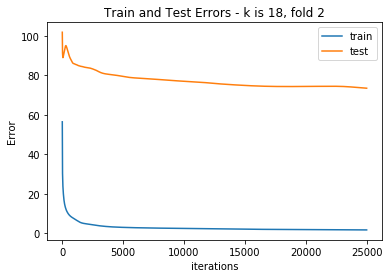

k:  18 ;  fold:  3 ;  cycle:  0
fit residual 9.066766375872174e-05
train residual 1.552
test residual 451.675

k:  18 ;  fold:  3 ;  cycle:  1
fit residual 8.021974241185969e-05
train residual 1.7504
test residual 117.7818

k:  18 ;  fold:  3 ;  cycle:  2
fit residual 7.207628203990901e-05
train residual 1.8197
test residual 3789182.6345

k:  18 ;  fold:  3 ;  cycle:  3
fit residual 6.664363125393684e-05
train residual 1.5462
test residual 94804.8727

k:  18 ;  fold:  3 ;  cycle:  4
fit residual 6.446769832614264e-05
train residual 1.5057
test residual 82.8944



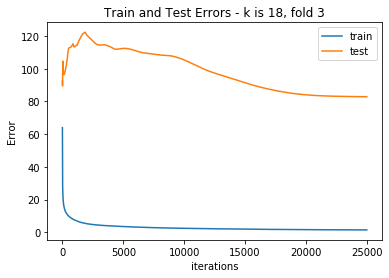

k:  19 ;  fold:  0 ;  cycle:  0
fit residual 7.686653080430178e-05
train residual 1.5943
test residual 49.7282

k:  19 ;  fold:  0 ;  cycle:  1
fit residual 6.569996032607418e-05
train residual 1.4039
test residual 74.5337

k:  19 ;  fold:  0 ;  cycle:  2
fit residual 0.00011687003484060421
train residual 1.9546
test residual 172.3196

k:  19 ;  fold:  0 ;  cycle:  3
fit residual 6.134201860997537e-05
train residual 1.3803
test residual 179.7857

k:  19 ;  fold:  0 ;  cycle:  4
fit residual 6.475738671182892e-05
train residual 1.793
test residual 1043420.5702



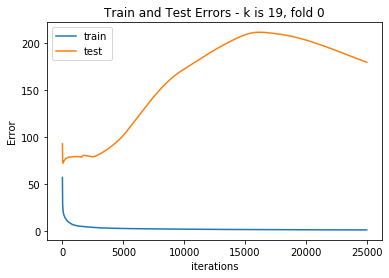

k:  19 ;  fold:  1 ;  cycle:  0
fit residual 5.0581609882323425e-05
train residual 1.2357
test residual 82.1062

k:  19 ;  fold:  1 ;  cycle:  1
fit residual 8.524207843339501e-05
train residual 1.627
test residual 86.2226

k:  19 ;  fold:  1 ;  cycle:  2
fit residual 5.04807002227502e-05
train residual 1.1013
test residual 82.8648

k:  19 ;  fold:  1 ;  cycle:  3
fit residual 5.7491531617620194e-05
train residual 1.1737
test residual 77533.6919

k:  19 ;  fold:  1 ;  cycle:  4
fit residual 6.672039321046142e-05
train residual 0.8845
test residual 35650.3047



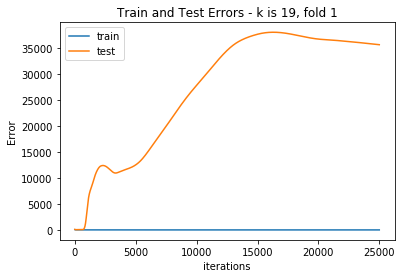

k:  19 ;  fold:  2 ;  cycle:  0
fit residual 9.230807991772311e-05
train residual 1.5221
test residual 53.1567

k:  19 ;  fold:  2 ;  cycle:  1
fit residual 4.470701666044735e-05
train residual 1.3696
test residual 655827.9095

k:  19 ;  fold:  2 ;  cycle:  2
fit residual 5.6065718808331846e-05
train residual 1.3971
test residual 51.0747

k:  19 ;  fold:  2 ;  cycle:  3
fit residual 8.916040007429077e-05
train residual 1.4212
test residual 78.6396

k:  19 ;  fold:  2 ;  cycle:  4
fit residual 6.240920873984928e-05
train residual 1.3139
test residual 219445.5818



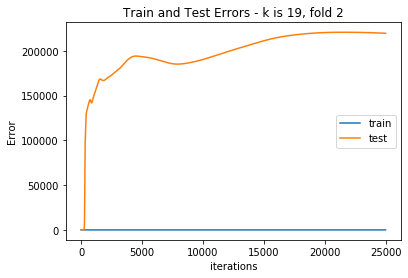

k:  19 ;  fold:  3 ;  cycle:  0
fit residual 4.722004931934755e-05
train residual 1.3706
test residual 102.2387

k:  19 ;  fold:  3 ;  cycle:  1
fit residual 9.921657986339223e-05
train residual 1.119
test residual 87.979

k:  19 ;  fold:  3 ;  cycle:  2
fit residual 3.956233684500357e-05
train residual 1.0409
test residual 81.6825

k:  19 ;  fold:  3 ;  cycle:  3
fit residual 6.115461020033413e-05
train residual 1.0503
test residual 94.4519

k:  19 ;  fold:  3 ;  cycle:  4
fit residual 5.9170247922088984e-05
train residual 1.2073
test residual 34845.1996



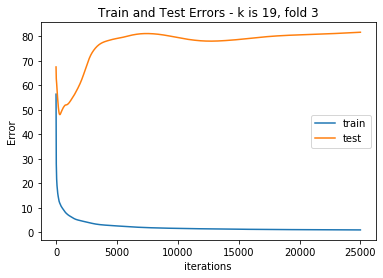

k:  20 ;  fold:  0 ;  cycle:  0
fit residual 8.36396468520776e-05
train residual 1.4965
test residual 95.105

k:  20 ;  fold:  0 ;  cycle:  1
fit residual 4.357606746022034e-05
train residual 1.0321
test residual 3079477.9216

k:  20 ;  fold:  0 ;  cycle:  2
fit residual 6.360869377218416e-05
train residual 1.1747
test residual 580830.9064

k:  20 ;  fold:  0 ;  cycle:  3
fit residual 5.8650130641175506e-05
train residual 1.0808
test residual 85.0152

k:  20 ;  fold:  0 ;  cycle:  4
fit residual 6.0086135746156226e-05
train residual 1.0325
test residual 59.1624



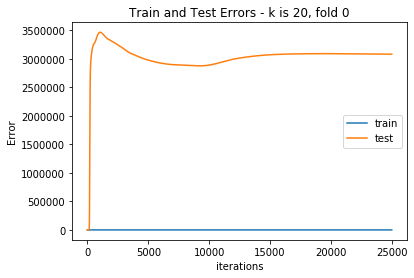

k:  20 ;  fold:  1 ;  cycle:  0
fit residual 4.130293394216152e-05
train residual 0.9784
test residual 274.2705

k:  20 ;  fold:  1 ;  cycle:  1
fit residual 2.342219594038318e-05
train residual 0.6603
test residual 74.0057

k:  20 ;  fold:  1 ;  cycle:  2
fit residual 4.2301218533391924e-05
train residual 0.6631
test residual 419471.7205

k:  20 ;  fold:  1 ;  cycle:  3
fit residual 3.851652880135061e-05
train residual 1.0939
test residual 418.5365

k:  20 ;  fold:  1 ;  cycle:  4
fit residual 7.372310229407101e-05
train residual 1.193
test residual 118.6099



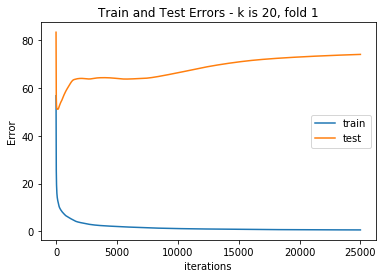

k:  20 ;  fold:  2 ;  cycle:  0
fit residual 6.42468765520641e-05
train residual 1.5915
test residual 210421.8644

k:  20 ;  fold:  2 ;  cycle:  1
fit residual 5.4066442293816616e-05
train residual 1.4063
test residual 172.4393

k:  20 ;  fold:  2 ;  cycle:  2
fit residual 5.4301397303250114e-05
train residual 1.3674
test residual 1181909.3731

k:  20 ;  fold:  2 ;  cycle:  3
fit residual 4.5431417573935884e-05
train residual 1.2809
test residual 95.9026

k:  20 ;  fold:  2 ;  cycle:  4
fit residual 6.226761768809173e-05
train residual 1.3608
test residual 84.1554



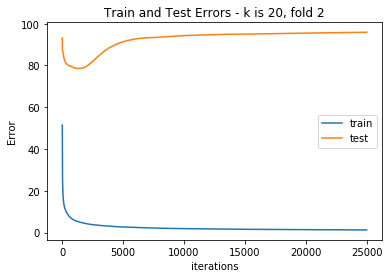

k:  20 ;  fold:  3 ;  cycle:  0
fit residual 5.0595283103189504e-05
train residual 0.9005
test residual 71.6087

k:  20 ;  fold:  3 ;  cycle:  1
fit residual 7.989733610674076e-05
train residual 1.3664
test residual 168.3988

k:  20 ;  fold:  3 ;  cycle:  2
fit residual 6.265959097610018e-05
train residual 1.0003
test residual 78.9453

k:  20 ;  fold:  3 ;  cycle:  3
fit residual 7.73076719614395e-05
train residual 1.0297
test residual 1240662.5535

k:  20 ;  fold:  3 ;  cycle:  4
fit residual 5.892687097646585e-05
train residual 1.0749
test residual 1435358.9599



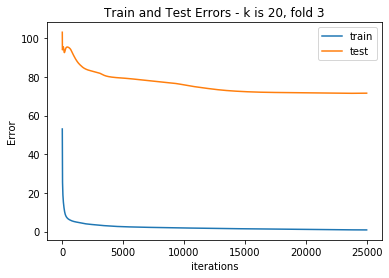

k:  21 ;  fold:  0 ;  cycle:  0
fit residual 3.1295215570917654e-05
train residual 0.8412
test residual 427808.0166

k:  21 ;  fold:  0 ;  cycle:  1
fit residual 6.135842836465797e-05
train residual 1.4346
test residual 147.8262

k:  21 ;  fold:  0 ;  cycle:  2
fit residual 4.983933862130145e-05
train residual 1.1993
test residual 77.9149

k:  21 ;  fold:  0 ;  cycle:  3
fit residual 5.995285464907607e-05
train residual 1.1839
test residual 603665.035

k:  21 ;  fold:  0 ;  cycle:  4
fit residual 5.010966846170165e-05
train residual 1.0024
test residual 297269.189



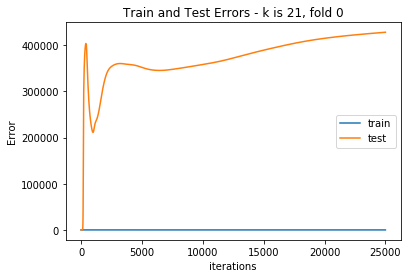

k:  21 ;  fold:  1 ;  cycle:  0
fit residual 4.030945324323267e-05
train residual 0.8598
test residual 1100636.176

k:  21 ;  fold:  1 ;  cycle:  1
fit residual 3.451799183520305e-05
train residual 0.724
test residual 153.2411

k:  21 ;  fold:  1 ;  cycle:  2
fit residual 5.196751440782448e-05
train residual 0.8494
test residual 4948140.3675

k:  21 ;  fold:  1 ;  cycle:  3
fit residual 4.902001030736954e-05
train residual 0.7231
test residual 95.1068

k:  21 ;  fold:  1 ;  cycle:  4
fit residual 5.8070993634396243e-05
train residual 0.828
test residual 81.5944



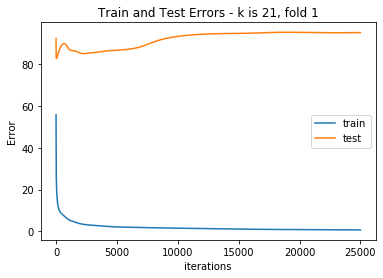

k:  21 ;  fold:  2 ;  cycle:  0
fit residual 4.4619276374097084e-05
train residual 1.0521
test residual 72.134

k:  21 ;  fold:  2 ;  cycle:  1
fit residual 4.386919712087086e-05
train residual 0.9758
test residual 118.6128

k:  21 ;  fold:  2 ;  cycle:  2
fit residual 4.1005944878618664e-05
train residual 0.9538
test residual 71.6885

k:  21 ;  fold:  2 ;  cycle:  3
fit residual 4.8889050925275775e-05
train residual 1.093
test residual 1507.1392

k:  21 ;  fold:  2 ;  cycle:  4
fit residual 4.43426590934557e-05
train residual 0.8861
test residual 754.8043



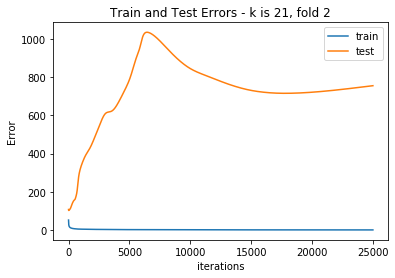

k:  21 ;  fold:  3 ;  cycle:  0
fit residual 4.4758430051762526e-05
train residual 0.7741
test residual 247.7081

k:  21 ;  fold:  3 ;  cycle:  1
fit residual 5.4655892161063055e-05
train residual 0.9032
test residual 87.7601

k:  21 ;  fold:  3 ;  cycle:  2
fit residual 5.402087287421238e-05
train residual 0.6214
test residual 59147.8186

k:  21 ;  fold:  3 ;  cycle:  3
fit residual 1.7560457592125217e-05
train residual 0.4618
test residual 51732.0039

k:  21 ;  fold:  3 ;  cycle:  4
fit residual 3.2707763256319574e-05
train residual 0.919
test residual 112.6864



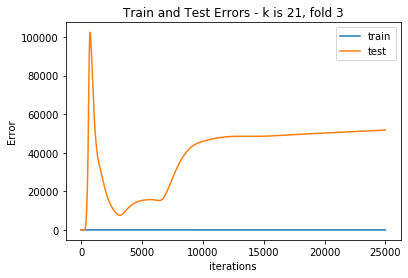

k:  22 ;  fold:  0 ;  cycle:  0
fit residual 4.7780823504970006e-05
train residual 0.6595
test residual 247629.2866

k:  22 ;  fold:  0 ;  cycle:  1
fit residual 4.8285187015129114e-05
train residual 0.9408
test residual 74.2366

k:  22 ;  fold:  0 ;  cycle:  2
fit residual 5.197189977036327e-05
train residual 0.8316
test residual 69.6546

k:  22 ;  fold:  0 ;  cycle:  3
fit residual 4.345246433358536e-05
train residual 0.7575
test residual 71.5687

k:  22 ;  fold:  0 ;  cycle:  4
fit residual 5.786686615616045e-05
train residual 0.8152
test residual 77.7972



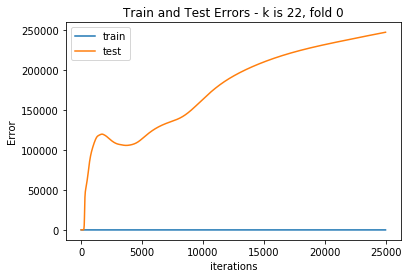

k:  22 ;  fold:  1 ;  cycle:  0
fit residual 2.9549048153749063e-05
train residual 0.6512
test residual 85960.7397

k:  22 ;  fold:  1 ;  cycle:  1
fit residual 2.6663939498753017e-05
train residual 0.4757
test residual 98.4023

k:  22 ;  fold:  1 ;  cycle:  2
fit residual 4.242700977723639e-05
train residual 0.664
test residual 105.6053

k:  22 ;  fold:  1 ;  cycle:  3
fit residual 2.6486025525327176e-05
train residual 0.5922
test residual 83.8373

k:  22 ;  fold:  1 ;  cycle:  4
fit residual 3.03705663510873e-05
train residual 0.4772
test residual 85.3651



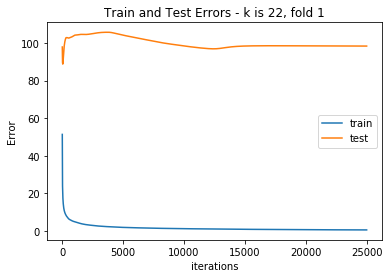

k:  22 ;  fold:  2 ;  cycle:  0
fit residual 4.148084390107001e-05
train residual 0.861
test residual 190.4678

k:  22 ;  fold:  2 ;  cycle:  1
fit residual 3.496464274883703e-05
train residual 0.6736
test residual 69.6362

k:  22 ;  fold:  2 ;  cycle:  2
fit residual 3.170345925173376e-05
train residual 0.7004
test residual 99.3509

k:  22 ;  fold:  2 ;  cycle:  3
fit residual 3.7769389945237345e-05
train residual 0.7524
test residual 78.7058

k:  22 ;  fold:  2 ;  cycle:  4
fit residual 3.594423668560358e-05
train residual 0.8576
test residual 86.0592



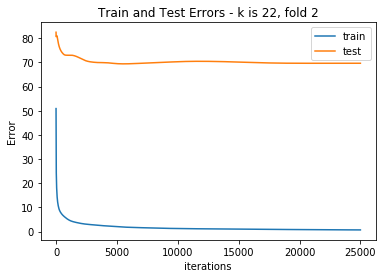

k:  22 ;  fold:  3 ;  cycle:  0
fit residual 2.8861738469346925e-05
train residual 0.5526
test residual 339644.3342

k:  22 ;  fold:  3 ;  cycle:  1
fit residual 2.5292011524377645e-05
train residual 0.4814
test residual 36422.0868

k:  22 ;  fold:  3 ;  cycle:  2
fit residual 3.131570596464088e-05
train residual 0.5306
test residual 336.863

k:  22 ;  fold:  3 ;  cycle:  3
fit residual 5.138222180072671e-05
train residual 0.7552
test residual 4766307.3957

k:  22 ;  fold:  3 ;  cycle:  4
fit residual 3.441138041476244e-05
train residual 0.6704
test residual 1253.7237



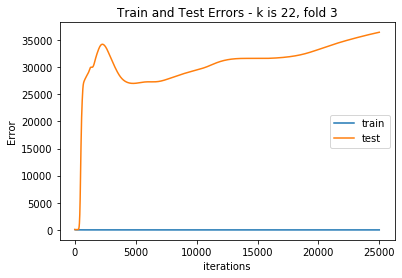

k:  23 ;  fold:  0 ;  cycle:  0
fit residual 2.141867376010848e-05
train residual 0.3835
test residual 60.6322

k:  23 ;  fold:  0 ;  cycle:  1
fit residual 2.978315579149666e-05
train residual 0.5915
test residual 73.0941

k:  23 ;  fold:  0 ;  cycle:  2
fit residual 3.872228069428434e-05
train residual 0.6593
test residual 88.6423

k:  23 ;  fold:  0 ;  cycle:  3
fit residual 6.097986425441341e-05
train residual 0.8826
test residual 146.1332

k:  23 ;  fold:  0 ;  cycle:  4
fit residual 2.6926728937188567e-05
train residual 0.9566
test residual 165176.8977



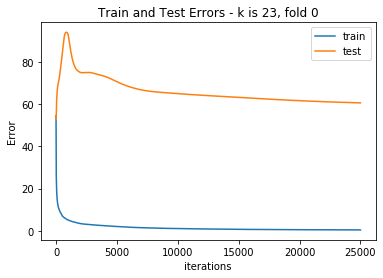

k:  23 ;  fold:  1 ;  cycle:  0
fit residual 2.0133342621239175e-05
train residual 0.3871
test residual 10051.2835

k:  23 ;  fold:  1 ;  cycle:  1
fit residual 2.6745922532497516e-05
train residual 0.4768
test residual 125.4579

k:  23 ;  fold:  1 ;  cycle:  2
fit residual 1.6613844023470992e-05
train residual 0.3561
test residual 957.5527

k:  23 ;  fold:  1 ;  cycle:  3
fit residual 2.4032138075493635e-05
train residual 0.2966
test residual 88.5787

k:  23 ;  fold:  1 ;  cycle:  4
fit residual 2.0403710158734533e-05
train residual 0.3624
test residual 95.2098



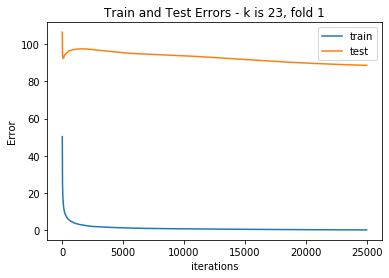

k:  23 ;  fold:  2 ;  cycle:  0
fit residual 4.207620383463549e-05
train residual 0.5814
test residual 547.7894

k:  23 ;  fold:  2 ;  cycle:  1
fit residual 1.7055218048901196e-05
train residual 0.3328
test residual 731563.0607

k:  23 ;  fold:  2 ;  cycle:  2
fit residual 3.3592740778280276e-05
train residual 0.7287
test residual 524558.149

k:  23 ;  fold:  2 ;  cycle:  3
fit residual 1.9719309539395528e-05
train residual 0.3309
test residual 77.0459

k:  23 ;  fold:  2 ;  cycle:  4
fit residual 3.520846417999487e-05
train residual 0.6031
test residual 63.5409



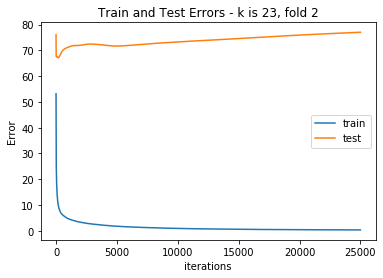

k:  23 ;  fold:  3 ;  cycle:  0
fit residual 2.245584659536336e-05
train residual 0.3524
test residual 85.9617

k:  23 ;  fold:  3 ;  cycle:  1
fit residual 2.1914801416044056e-05
train residual 0.2272
test residual 2017321.8917

k:  23 ;  fold:  3 ;  cycle:  2
fit residual 1.214804123848895e-05
train residual 0.2704
test residual 124.4147

k:  23 ;  fold:  3 ;  cycle:  3
fit residual 1.8043513239729233e-05
train residual 0.2233
test residual 102.7641

k:  23 ;  fold:  3 ;  cycle:  4
fit residual 1.8709242319413165e-05
train residual 0.147
test residual 468973.3433



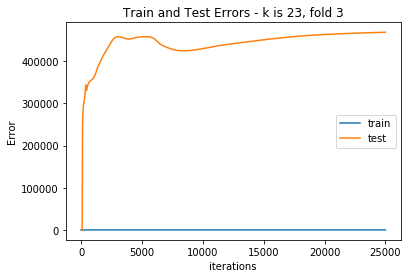

k:  24 ;  fold:  0 ;  cycle:  0
fit residual 2.256690870674478e-05
train residual 0.3493
test residual 105.2869

k:  24 ;  fold:  0 ;  cycle:  1
fit residual 3.9558804463773804e-05
train residual 0.3963
test residual 132.5866

k:  24 ;  fold:  0 ;  cycle:  2
fit residual 2.8698603374662752e-05
train residual 0.4384
test residual 115.3174

k:  24 ;  fold:  0 ;  cycle:  3
fit residual 1.6076192754881622e-05
train residual 0.3334
test residual 801742.7055

k:  24 ;  fold:  0 ;  cycle:  4
fit residual 4.7141867146997994e-05
train residual 0.7282
test residual 11509.9744



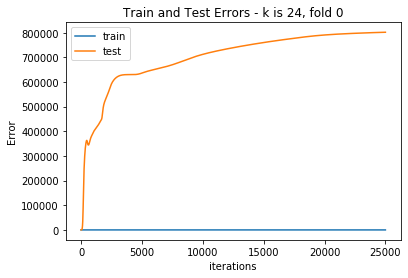

k:  24 ;  fold:  1 ;  cycle:  0
fit residual 1.1997157820631643e-05
train residual 0.1969
test residual 998.5657

k:  24 ;  fold:  1 ;  cycle:  1
fit residual 1.4760944102135568e-05
train residual 0.2569
test residual 95.8936

k:  24 ;  fold:  1 ;  cycle:  2
fit residual 1.878418936189608e-05
train residual 0.3243
test residual 80.0106

k:  24 ;  fold:  1 ;  cycle:  3
fit residual 2.2391783895265888e-05
train residual 0.4598
test residual 43241.7549

k:  24 ;  fold:  1 ;  cycle:  4
fit residual 5.810935246137594e-06
train residual 0.0766
test residual 89.1074



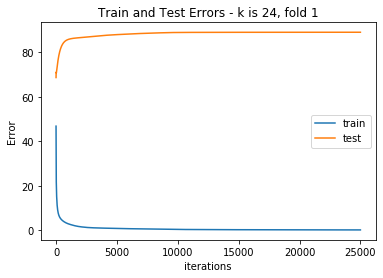

k:  24 ;  fold:  2 ;  cycle:  0
fit residual 1.4219627934109305e-05
train residual 0.3535
test residual 123.622

k:  24 ;  fold:  2 ;  cycle:  1
fit residual 2.388794395492789e-05
train residual 0.3768
test residual 465.0226

k:  24 ;  fold:  2 ;  cycle:  2
fit residual 3.205760239941506e-05
train residual 0.3553
test residual 33200.6517

k:  24 ;  fold:  2 ;  cycle:  3
fit residual 2.145133710756125e-05
train residual 0.2903
test residual 99.2373

k:  24 ;  fold:  2 ;  cycle:  4
fit residual 1.7603699987450637e-05
train residual 0.231
test residual 95.9002



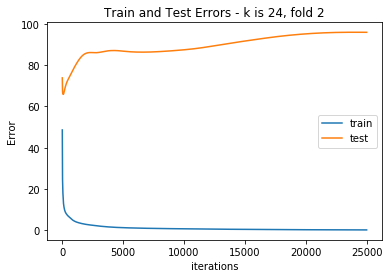

k:  24 ;  fold:  3 ;  cycle:  0
fit residual 9.58892145739715e-06
train residual 0.2359
test residual 80.4905

k:  24 ;  fold:  3 ;  cycle:  1
fit residual 1.9467398878647202e-05
train residual 0.2343
test residual 62.9056

k:  24 ;  fold:  3 ;  cycle:  2
fit residual 1.543220044823059e-05
train residual 0.2761
test residual 1552962.1408

k:  24 ;  fold:  3 ;  cycle:  3
fit residual 8.288692506748202e-06
train residual 0.1497
test residual 103.6032

k:  24 ;  fold:  3 ;  cycle:  4
fit residual 1.9063603538315987e-05
train residual 0.2447
test residual 53853.0237



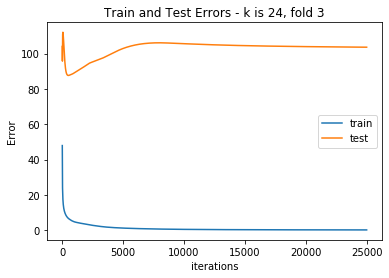

In [19]:
# Run multiple k and capture results

n_iter = 25000
k_tup_list = []
# k must be lower than the min of (columns/rows)
k_max = min(orig_matrix_round_plus.shape[0], orig_matrix_round_plus.shape[1])
for k in range(2,k_max):     

    train_mean, test_mean, final_As, final_Ys = nmf_cv(orig_matrix_round_plus, k, max_iter=n_iter)
    k_tup = (train_mean, test_mean, final_As, final_Ys, k)
    k_tup_list.append(k_tup)
      

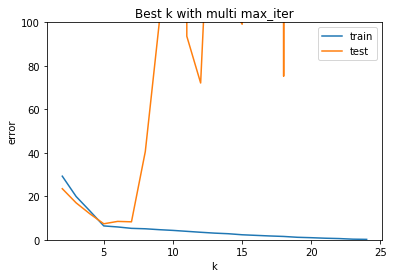

Best (lowest) error is 7.365619828337622, with 5 latent features


In [20]:
# Extracting the best run
# Get the min test error and its index
test_err = [tup[1] for tup in k_tup_list]
min_test_err = np.min(test_err)
min_test_err_idx = test_err.index(min_test_err)
# Extract the run and its attributes
best_run = k_tup_list[min_test_err_idx]
best_k = min_test_err_idx + 2 

test_vals = [x[1] for x in k_tup_list]
train_vals = [x[0] for x in k_tup_list]
# plot
plt.plot(np.arange(2,len(train_vals)+2), train_vals, label="train")
plt.plot(np.arange(2,len(test_vals)+2), test_vals, label="test")
plt.title("Best k with multi max_iter")
plt.xlabel("k")
plt.ylabel("error")
plt.ylim(0,100)
plt.legend()
plt.show()

print("Best (lowest) error is {}, with {} latent features".format(min_test_err, best_k))  

## 6. Capturing A and Y

In [21]:
# We know that the index of k=5 is 3 (we started the for loop with 2).
# So we get the four A matrices and four Y matrices
As = k_tup_list[3][2]
Ys = k_tup_list[3][3]
# We pick one A and one Y
A_0 = As[0]
Y_0 = Ys[0]

In [22]:
A_0.shape

(40, 5)

In [23]:
Y_0.shape

(5, 25)

## 7. Train with Optimized k and Captured A/Y Matrices

In [24]:
def nmf(X, max_iter, init_A, init_Y, cycles=5):
    """
    Decompose X to A*Y
    """
    eps = 1e-7
    # mask: take only the non-nan location for loss calculation
    mask = ~np.isnan(X)
    # Fill in nan to 0
    X = np.nan_to_num(X)
    # Takes several cycles to get the minimum loss between them
    result_list = []
    for j in range(cycles): 
        # A as we captured
        A =init_A
        A = np.maximum(A, eps)

        # Y as we captured
        Y = init_Y
        Y = np.maximum(Y, eps)

        masked_X = mask * X
        X_est_prev = np.dot(A, Y)
    
        for i in tqdm(range(1, max_iter + 1), "cycle_{}".format(j)):
            # ===== updates =====
            top = np.dot(masked_X, Y.T)
            bottom = (np.dot((mask * np.dot(A, Y)), Y.T)) + eps
            A *= top / bottom
            A = np.maximum(A, eps)

            top = np.dot(A.T, masked_X)
            bottom = np.dot(A.T, mask * np.dot(A, Y)) + eps
            Y *= top / bottom
            Y = np.maximum(Y, eps)

            # ==== evaluation ====
            if i % 5 == 0 or i == 1 or i == max_iter:
                print('Iteration {}:'.format(i))
                X_est = np.dot(A, Y)
                err = mask * (X_est_prev - X_est)
                fit_residual = np.sqrt(np.sum(err ** 2))
                X_est_prev = X_est

                curRes = linalg.norm(mask * (X - X_est), ord='fro')
                print('fit residual', np.round(fit_residual, 4))
                print('total residual', np.round(curRes, 4))

        result_list.append((A, Y, curRes))
        
    result_list_sorted = list(sorted(result_list, key=lambda x: x[2]))    
        
    return result_list_sorted[0][0], result_list_sorted[0][1], result_list_sorted[0][2] #

In [25]:
# Get the factor matrices 
A, Y, err = nmf(orig_matrix_round_plus, 10000, A_0, Y_0)

cycle_0:   8%|▊         | 845/10000 [00:00<00:01, 8444.01it/s]

Iteration 1:
fit residual 3.5395
total residual 9.0689
Iteration 5:
fit residual 1.4296
total residual 8.755
Iteration 10:
fit residual 0.6883
total residual 8.6421
Iteration 15:
fit residual 0.3531
total residual 8.588
Iteration 20:
fit residual 0.232
total residual 8.5526
Iteration 25:
fit residual 0.1739
total residual 8.5263
Iteration 30:
fit residual 0.1394
total residual 8.5054
Iteration 35:
fit residual 0.1164
total residual 8.4882
Iteration 40:
fit residual 0.0998
total residual 8.4736
Iteration 45:
fit residual 0.0874
total residual 8.4609
Iteration 50:
fit residual 0.0776
total residual 8.4498
Iteration 55:
fit residual 0.0698
total residual 8.4399
Iteration 60:
fit residual 0.0634
total residual 8.431
Iteration 65:
fit residual 0.058
total residual 8.4229
Iteration 70:
fit residual 0.0535
total residual 8.4156
Iteration 75:
fit residual 0.0495
total residual 8.4088
Iteration 80:
fit residual 0.0461
total residual 8.4025
Iteration 85:
fit residual 0.0431
total residual 8.3967

cycle_0:  16%|█▌        | 1591/10000 [00:00<00:01, 8119.76it/s]

fit residual 0.0103
total residual 7.9791
Iteration 1380:
fit residual 0.0104
total residual 7.9771
Iteration 1385:
fit residual 0.0105
total residual 7.9752
Iteration 1390:
fit residual 0.0105
total residual 7.9732
Iteration 1395:
fit residual 0.0106
total residual 7.9713
Iteration 1400:
fit residual 0.0106
total residual 7.9694
Iteration 1405:
fit residual 0.0107
total residual 7.9674
Iteration 1410:
fit residual 0.0107
total residual 7.9655
Iteration 1415:
fit residual 0.0108
total residual 7.9636
Iteration 1420:
fit residual 0.0108
total residual 7.9616
Iteration 1425:
fit residual 0.0109
total residual 7.9597
Iteration 1430:
fit residual 0.0109
total residual 7.9578
Iteration 1435:
fit residual 0.011
total residual 7.9559
Iteration 1440:
fit residual 0.011
total residual 7.954
Iteration 1445:
fit residual 0.0111
total residual 7.9521
Iteration 1450:
fit residual 0.0111
total residual 7.9502
Iteration 1455:
fit residual 0.0111
total residual 7.9484
Iteration 1460:
fit residual 0.01

cycle_0:  22%|██▏       | 2220/10000 [00:00<00:01, 7460.59it/s]

Iteration 1595:
fit residual 0.0109
total residual 7.9013
Iteration 1600:
fit residual 0.0108
total residual 7.8999
Iteration 1605:
fit residual 0.0108
total residual 7.8985
Iteration 1610:
fit residual 0.0107
total residual 7.8971
Iteration 1615:
fit residual 0.0107
total residual 7.8957
Iteration 1620:
fit residual 0.0106
total residual 7.8943
Iteration 1625:
fit residual 0.0105
total residual 7.893
Iteration 1630:
fit residual 0.0105
total residual 7.8917
Iteration 1635:
fit residual 0.0104
total residual 7.8904
Iteration 1640:
fit residual 0.0103
total residual 7.8891
Iteration 1645:
fit residual 0.0103
total residual 7.8878
Iteration 1650:
fit residual 0.0102
total residual 7.8866
Iteration 1655:
fit residual 0.0101
total residual 7.8854
Iteration 1660:
fit residual 0.01
total residual 7.8842
Iteration 1665:
fit residual 0.01
total residual 7.883
Iteration 1670:
fit residual 0.0099
total residual 7.8818
Iteration 1675:
fit residual 0.0098
total residual 7.8806
Iteration 1680:
fit 

cycle_0:  29%|██▉       | 2920/10000 [00:00<00:00, 7313.70it/s]

Iteration 2645:
fit residual 0.0018
total residual 7.8069
Iteration 2650:
fit residual 0.0018
total residual 7.8068
Iteration 2655:
fit residual 0.0018
total residual 7.8067
Iteration 2660:
fit residual 0.0018
total residual 7.8066
Iteration 2665:
fit residual 0.0017
total residual 7.8064
Iteration 2670:
fit residual 0.0017
total residual 7.8063
Iteration 2675:
fit residual 0.0017
total residual 7.8062
Iteration 2680:
fit residual 0.0017
total residual 7.8061
Iteration 2685:
fit residual 0.0017
total residual 7.8059
Iteration 2690:
fit residual 0.0017
total residual 7.8058
Iteration 2695:
fit residual 0.0017
total residual 7.8057
Iteration 2700:
fit residual 0.0017
total residual 7.8056
Iteration 2705:
fit residual 0.0017
total residual 7.8054
Iteration 2710:
fit residual 0.0017
total residual 7.8053
Iteration 2715:
fit residual 0.0016
total residual 7.8052
Iteration 2720:
fit residual 0.0016
total residual 7.805
Iteration 2725:
fit residual 0.0016
total residual 7.8049
Iteration 2730:

cycle_0:  37%|███▋      | 3741/10000 [00:00<00:00, 7557.60it/s]

fit residual 0.0015
total residual 7.7992
Iteration 2930:
fit residual 0.0015
total residual 7.7991
Iteration 2935:
fit residual 0.0015
total residual 7.7989
Iteration 2940:
fit residual 0.0015
total residual 7.7987
Iteration 2945:
fit residual 0.0015
total residual 7.7985
Iteration 2950:
fit residual 0.0015
total residual 7.7984
Iteration 2955:
fit residual 0.0015
total residual 7.7982
Iteration 2960:
fit residual 0.0015
total residual 7.798
Iteration 2965:
fit residual 0.0015
total residual 7.7978
Iteration 2970:
fit residual 0.0015
total residual 7.7976
Iteration 2975:
fit residual 0.0015
total residual 7.7975
Iteration 2980:
fit residual 0.0015
total residual 7.7973
Iteration 2985:
fit residual 0.0015
total residual 7.7971
Iteration 2990:
fit residual 0.0015
total residual 7.7969
Iteration 2995:
fit residual 0.0015
total residual 7.7967
Iteration 3000:
fit residual 0.0015
total residual 7.7965
Iteration 3005:
fit residual 0.0015
total residual 7.7963
Iteration 3010:
fit residual 0.

cycle_0:  46%|████▌     | 4570/10000 [00:00<00:00, 7760.97it/s]

fit residual 0.003
total residual 7.6727
Iteration 4305:
fit residual 0.003
total residual 7.6724
Iteration 4310:
fit residual 0.003
total residual 7.6722
Iteration 4315:
fit residual 0.003
total residual 7.672
Iteration 4320:
fit residual 0.0029
total residual 7.6718
Iteration 4325:
fit residual 0.0029
total residual 7.6715
Iteration 4330:
fit residual 0.0029
total residual 7.6713
Iteration 4335:
fit residual 0.0029
total residual 7.6711
Iteration 4340:
fit residual 0.0028
total residual 7.6709
Iteration 4345:
fit residual 0.0028
total residual 7.6707
Iteration 4350:
fit residual 0.0028
total residual 7.6705
Iteration 4355:
fit residual 0.0028
total residual 7.6702
Iteration 4360:
fit residual 0.0027
total residual 7.67
Iteration 4365:
fit residual 0.0027
total residual 7.6698
Iteration 4370:
fit residual 0.0027
total residual 7.6696
Iteration 4375:
fit residual 0.0027
total residual 7.6694
Iteration 4380:
fit residual 0.0026
total residual 7.6692
Iteration 4385:
fit residual 0.0026
t

cycle_0:  54%|█████▍    | 5376/10000 [00:00<00:00, 7843.02it/s]

Iteration 4580:
fit residual 0.0021
total residual 7.6613
Iteration 4585:
fit residual 0.0021
total residual 7.6611
Iteration 4590:
fit residual 0.002
total residual 7.6609
Iteration 4595:
fit residual 0.002
total residual 7.6607
Iteration 4600:
fit residual 0.002
total residual 7.6605
Iteration 4605:
fit residual 0.002
total residual 7.6603
Iteration 4610:
fit residual 0.002
total residual 7.6601
Iteration 4615:
fit residual 0.002
total residual 7.6599
Iteration 4620:
fit residual 0.002
total residual 7.6598
Iteration 4625:
fit residual 0.002
total residual 7.6596
Iteration 4630:
fit residual 0.002
total residual 7.6594
Iteration 4635:
fit residual 0.002
total residual 7.6592
Iteration 4640:
fit residual 0.002
total residual 7.659
Iteration 4645:
fit residual 0.0019
total residual 7.6588
Iteration 4650:
fit residual 0.0019
total residual 7.6586
Iteration 4655:
fit residual 0.0019
total residual 7.6584
Iteration 4660:
fit residual 0.0019
total residual 7.6582
Iteration 4665:
fit residu

cycle_0:  62%|██████▏   | 6170/10000 [00:00<00:00, 7866.11it/s]

Iteration 5915:
fit residual 0.0044
total residual 7.5698
Iteration 5920:
fit residual 0.0044
total residual 7.5694
Iteration 5925:
fit residual 0.0044
total residual 7.569
Iteration 5930:
fit residual 0.0044
total residual 7.5686
Iteration 5935:
fit residual 0.0044
total residual 7.5682
Iteration 5940:
fit residual 0.0044
total residual 7.5678
Iteration 5945:
fit residual 0.0044
total residual 7.5674
Iteration 5950:
fit residual 0.0043
total residual 7.567
Iteration 5955:
fit residual 0.0043
total residual 7.5666
Iteration 5960:
fit residual 0.0043
total residual 7.5662
Iteration 5965:
fit residual 0.0043
total residual 7.5658
Iteration 5970:
fit residual 0.0043
total residual 7.5654
Iteration 5975:
fit residual 0.0043
total residual 7.565
Iteration 5980:
fit residual 0.0043
total residual 7.5647
Iteration 5985:
fit residual 0.0043
total residual 7.5643
Iteration 5990:
fit residual 0.0042
total residual 7.5639
Iteration 5995:
fit residual 0.0042
total residual 7.5635
Iteration 6000:
f

cycle_0:  69%|██████▉   | 6926/10000 [00:00<00:00, 7771.64it/s]

Iteration 6185:
fit residual 0.0035
total residual 7.5512
Iteration 6190:
fit residual 0.0035
total residual 7.5509
Iteration 6195:
fit residual 0.0035
total residual 7.5507
Iteration 6200:
fit residual 0.0035
total residual 7.5504
Iteration 6205:
fit residual 0.0034
total residual 7.5501
Iteration 6210:
fit residual 0.0034
total residual 7.5498
Iteration 6215:
fit residual 0.0034
total residual 7.5496
Iteration 6220:
fit residual 0.0034
total residual 7.5493
Iteration 6225:
fit residual 0.0034
total residual 7.549
Iteration 6230:
fit residual 0.0033
total residual 7.5487
Iteration 6235:
fit residual 0.0033
total residual 7.5485
Iteration 6240:
fit residual 0.0033
total residual 7.5482
Iteration 6245:
fit residual 0.0033
total residual 7.5479
Iteration 6250:
fit residual 0.0033
total residual 7.5477
Iteration 6255:
fit residual 0.0032
total residual 7.5474
Iteration 6260:
fit residual 0.0032
total residual 7.5471
Iteration 6265:
fit residual 0.0032
total residual 7.5469
Iteration 6270:

cycle_0:  77%|███████▋  | 7726/10000 [00:01<00:00, 7834.29it/s]

fit residual 0.0063
total residual 7.427
Iteration 7470:
fit residual 0.0063
total residual 7.4263
Iteration 7475:
fit residual 0.0063
total residual 7.4255
Iteration 7480:
fit residual 0.0063
total residual 7.4247
Iteration 7485:
fit residual 0.0063
total residual 7.424
Iteration 7490:
fit residual 0.0063
total residual 7.4232
Iteration 7495:
fit residual 0.0063
total residual 7.4225
Iteration 7500:
fit residual 0.0063
total residual 7.4217
Iteration 7505:
fit residual 0.0063
total residual 7.421
Iteration 7510:
fit residual 0.0063
total residual 7.4203
Iteration 7515:
fit residual 0.0063
total residual 7.4195
Iteration 7520:
fit residual 0.0063
total residual 7.4188
Iteration 7525:
fit residual 0.0063
total residual 7.4181
Iteration 7530:
fit residual 0.0063
total residual 7.4174
Iteration 7535:
fit residual 0.0063
total residual 7.4167
Iteration 7540:
fit residual 0.0063
total residual 7.416
Iteration 7545:
fit residual 0.0062
total residual 7.4153
Iteration 7550:
fit residual 0.006

cycle_0:  85%|████████▍ | 8488/10000 [00:01<00:00, 7474.65it/s]

Iteration 7745:
fit residual 0.0053
total residual 7.3917
Iteration 7750:
fit residual 0.0052
total residual 7.3912
Iteration 7755:
fit residual 0.0052
total residual 7.3907
Iteration 7760:
fit residual 0.0052
total residual 7.3902
Iteration 7765:
fit residual 0.0051
total residual 7.3898
Iteration 7770:
fit residual 0.0051
total residual 7.3893
Iteration 7775:
fit residual 0.005
total residual 7.3889
Iteration 7780:
fit residual 0.005
total residual 7.3884
Iteration 7785:
fit residual 0.005
total residual 7.388
Iteration 7790:
fit residual 0.0049
total residual 7.3875
Iteration 7795:
fit residual 0.0049
total residual 7.3871
Iteration 7800:
fit residual 0.0049
total residual 7.3866
Iteration 7805:
fit residual 0.0048
total residual 7.3862
Iteration 7810:
fit residual 0.0048
total residual 7.3858
Iteration 7815:
fit residual 0.0048
total residual 7.3854
Iteration 7820:
fit residual 0.0047
total residual 7.3849
Iteration 7825:
fit residual 0.0047
total residual 7.3845
Iteration 7830:
fi

Iteration 8875:
fit residual 0.0021
total residual 7.3352
Iteration 8880:
fit residual 0.0021
total residual 7.335
Iteration 8885:
fit residual 0.0021
total residual 7.3349
Iteration 8890:
fit residual 0.0021
total residual 7.3347
Iteration 8895:
fit residual 0.002
total residual 7.3345
Iteration 8900:
fit residual 0.002
total residual 7.3343
Iteration 8905:
fit residual 0.002
total residual 7.3342
Iteration 8910:
fit residual 0.002
total residual 7.334
Iteration 8915:
fit residual 0.002
total residual 7.3338
Iteration 8920:
fit residual 0.002
total residual 7.3336
Iteration 8925:
fit residual 0.002
total residual 7.3335
Iteration 8930:
fit residual 0.002
total residual 7.3333
Iteration 8935:
fit residual 0.002
total residual 7.3331
Iteration 8940:
fit residual 0.002
total residual 7.3329
Iteration 8945:
fit residual 0.002
total residual 7.3328
Iteration 8950:
fit residual 0.002
total residual 7.3326
Iteration 8955:
fit residual 0.002
total residual 7.3324
Iteration 8960:
fit residual 

cycle_1:   0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 9080:
fit residual 0.002
total residual 7.3281
Iteration 9085:
fit residual 0.002
total residual 7.328
Iteration 9090:
fit residual 0.002
total residual 7.3278
Iteration 9095:
fit residual 0.002
total residual 7.3276
Iteration 9100:
fit residual 0.002
total residual 7.3275
Iteration 9105:
fit residual 0.002
total residual 7.3273
Iteration 9110:
fit residual 0.002
total residual 7.3271
Iteration 9115:
fit residual 0.002
total residual 7.3269
Iteration 9120:
fit residual 0.002
total residual 7.3268
Iteration 9125:
fit residual 0.002
total residual 7.3266
Iteration 9130:
fit residual 0.002
total residual 7.3264
Iteration 9135:
fit residual 0.002
total residual 7.3263
Iteration 9140:
fit residual 0.002
total residual 7.3261
Iteration 9145:
fit residual 0.002
total residual 7.3259
Iteration 9150:
fit residual 0.002
total residual 7.3258
Iteration 9155:
fit residual 0.002
total residual 7.3256
Iteration 9160:
fit residual 0.002
total residual 7.3254
Iteration 9165:
fit residual 0.0

fit residual 0.1394
total residual 8.5054
Iteration 35:
fit residual 0.1164
total residual 8.4882
Iteration 40:
fit residual 0.0998
total residual 8.4736
Iteration 45:
fit residual 0.0874
total residual 8.4609
Iteration 50:
fit residual 0.0776
total residual 8.4498
Iteration 55:
fit residual 0.0698
total residual 8.4399
Iteration 60:
fit residual 0.0634
total residual 8.431
Iteration 65:
fit residual 0.058
total residual 8.4229
Iteration 70:
fit residual 0.0535
total residual 8.4156
Iteration 75:
fit residual 0.0495
total residual 8.4088
Iteration 80:
fit residual 0.0461
total residual 8.4025
Iteration 85:
fit residual 0.0431
total residual 8.3967
Iteration 90:
fit residual 0.0404
total residual 8.3913
Iteration 95:
fit residual 0.0381
total residual 8.3862
Iteration 100:
fit residual 0.036
total residual 8.3814
Iteration 105:
fit residual 0.0341
total residual 8.3769
Iteration 110:
fit residual 0.0324
total residual 8.3726
Iteration 115:
fit residual 0.0308
total residual 8.3685
Itera

cycle_1:  15%|█▌        | 1515/10000 [00:00<00:01, 7268.87it/s]

Iteration 245:
fit residual 0.0141
total residual 8.3024
Iteration 250:
fit residual 0.0138
total residual 8.3007
Iteration 255:
fit residual 0.0135
total residual 8.299
Iteration 260:
fit residual 0.0133
total residual 8.2973
Iteration 265:
fit residual 0.013
total residual 8.2957
Iteration 270:
fit residual 0.0128
total residual 8.2941
Iteration 275:
fit residual 0.0126
total residual 8.2926
Iteration 280:
fit residual 0.0123
total residual 8.291
Iteration 285:
fit residual 0.0121
total residual 8.2895
Iteration 290:
fit residual 0.0119
total residual 8.288
Iteration 295:
fit residual 0.0117
total residual 8.2866
Iteration 300:
fit residual 0.0115
total residual 8.2851
Iteration 305:
fit residual 0.0113
total residual 8.2837
Iteration 310:
fit residual 0.0111
total residual 8.2823
Iteration 315:
fit residual 0.011
total residual 8.2809
Iteration 320:
fit residual 0.0108
total residual 8.2796
Iteration 325:
fit residual 0.0106
total residual 8.2782
Iteration 330:
fit residual 0.0105
t

fit residual 0.0111
total residual 7.9088
Iteration 1575:
fit residual 0.0111
total residual 7.9073
Iteration 1580:
fit residual 0.011
total residual 7.9057
Iteration 1585:
fit residual 0.011
total residual 7.9043
Iteration 1590:
fit residual 0.0109
total residual 7.9028
Iteration 1595:
fit residual 0.0109
total residual 7.9013
Iteration 1600:
fit residual 0.0108
total residual 7.8999
Iteration 1605:
fit residual 0.0108
total residual 7.8985
Iteration 1610:
fit residual 0.0107
total residual 7.8971
Iteration 1615:
fit residual 0.0107
total residual 7.8957
Iteration 1620:
fit residual 0.0106
total residual 7.8943
Iteration 1625:
fit residual 0.0105
total residual 7.893
Iteration 1630:
fit residual 0.0105
total residual 7.8917
Iteration 1635:
fit residual 0.0104
total residual 7.8904
Iteration 1640:
fit residual 0.0103
total residual 7.8891
Iteration 1645:
fit residual 0.0103
total residual 7.8878
Iteration 1650:
fit residual 0.0102
total residual 7.8866
Iteration 1655:
fit residual 0.01

cycle_1:  31%|███▏      | 3126/10000 [00:00<00:00, 7661.00it/s]

fit residual 0.0069
total residual 7.8492
Iteration 1860:
fit residual 0.0069
total residual 7.8486
Iteration 1865:
fit residual 0.0068
total residual 7.848
Iteration 1870:
fit residual 0.0067
total residual 7.8473
Iteration 1875:
fit residual 0.0067
total residual 7.8467
Iteration 1880:
fit residual 0.0066
total residual 7.8461
Iteration 1885:
fit residual 0.0065
total residual 7.8455
Iteration 1890:
fit residual 0.0065
total residual 7.8449
Iteration 1895:
fit residual 0.0064
total residual 7.8444
Iteration 1900:
fit residual 0.0063
total residual 7.8438
Iteration 1905:
fit residual 0.0063
total residual 7.8433
Iteration 1910:
fit residual 0.0062
total residual 7.8427
Iteration 1915:
fit residual 0.0061
total residual 7.8422
Iteration 1920:
fit residual 0.0061
total residual 7.8416
Iteration 1925:
fit residual 0.006
total residual 7.8411
Iteration 1930:
fit residual 0.006
total residual 7.8406
Iteration 1935:
fit residual 0.0059
total residual 7.8401
Iteration 1940:
fit residual 0.00

fit residual 0.0022
total residual 7.7867
Iteration 3195:
fit residual 0.0022
total residual 7.7864
Iteration 3200:
fit residual 0.0022
total residual 7.786
Iteration 3205:
fit residual 0.0023
total residual 7.7857
Iteration 3210:
fit residual 0.0023
total residual 7.7853
Iteration 3215:
fit residual 0.0023
total residual 7.785
Iteration 3220:
fit residual 0.0023
total residual 7.7846
Iteration 3225:
fit residual 0.0024
total residual 7.7842
Iteration 3230:
fit residual 0.0024
total residual 7.7839
Iteration 3235:
fit residual 0.0024
total residual 7.7835
Iteration 3240:
fit residual 0.0025
total residual 7.7831
Iteration 3245:
fit residual 0.0025
total residual 7.7827
Iteration 3250:
fit residual 0.0026
total residual 7.7823
Iteration 3255:
fit residual 0.0026
total residual 7.7819
Iteration 3260:
fit residual 0.0026
total residual 7.7815
Iteration 3265:
fit residual 0.0027
total residual 7.7811
Iteration 3270:
fit residual 0.0027
total residual 7.7807
Iteration 3275:
fit residual 0.0

cycle_1:  46%|████▋     | 4647/10000 [00:00<00:00, 7661.45it/s]

Iteration 3390:
fit residual 0.0038
total residual 7.769
Iteration 3395:
fit residual 0.0038
total residual 7.7684
Iteration 3400:
fit residual 0.0039
total residual 7.7679
Iteration 3405:
fit residual 0.0039
total residual 7.7673
Iteration 3410:
fit residual 0.004
total residual 7.7667
Iteration 3415:
fit residual 0.004
total residual 7.7661
Iteration 3420:
fit residual 0.0041
total residual 7.7655
Iteration 3425:
fit residual 0.0042
total residual 7.7649
Iteration 3430:
fit residual 0.0042
total residual 7.7643
Iteration 3435:
fit residual 0.0043
total residual 7.7637
Iteration 3440:
fit residual 0.0043
total residual 7.7631
Iteration 3445:
fit residual 0.0044
total residual 7.7625
Iteration 3450:
fit residual 0.0044
total residual 7.7618
Iteration 3455:
fit residual 0.0045
total residual 7.7612
Iteration 3460:
fit residual 0.0045
total residual 7.7606
Iteration 3465:
fit residual 0.0046
total residual 7.7599
Iteration 3470:
fit residual 0.0046
total residual 7.7593
Iteration 3475:
f

fit residual 0.0019
total residual 7.6569
Iteration 4700:
fit residual 0.0019
total residual 7.6567
Iteration 4705:
fit residual 0.0019
total residual 7.6565
Iteration 4710:
fit residual 0.0019
total residual 7.6563
Iteration 4715:
fit residual 0.0019
total residual 7.6561
Iteration 4720:
fit residual 0.0018
total residual 7.6559
Iteration 4725:
fit residual 0.0018
total residual 7.6557
Iteration 4730:
fit residual 0.0018
total residual 7.6555
Iteration 4735:
fit residual 0.0018
total residual 7.6553
Iteration 4740:
fit residual 0.0018
total residual 7.6551
Iteration 4745:
fit residual 0.0018
total residual 7.6549
Iteration 4750:
fit residual 0.0018
total residual 7.6547
Iteration 4755:
fit residual 0.0018
total residual 7.6545
Iteration 4760:
fit residual 0.0018
total residual 7.6543
Iteration 4765:
fit residual 0.0018
total residual 7.6541
Iteration 4770:
fit residual 0.0018
total residual 7.6539
Iteration 4775:
fit residual 0.0018
total residual 7.6537
Iteration 4780:
fit residual 0

cycle_1:  53%|█████▎    | 5338/10000 [00:00<00:00, 6966.58it/s]

0.0017
total residual 7.6489
Iteration 4895:
fit residual 0.0017
total residual 7.6487
Iteration 4900:
fit residual 0.0017
total residual 7.6485
Iteration 4905:
fit residual 0.0017
total residual 7.6483
Iteration 4910:
fit residual 0.0017
total residual 7.6481
Iteration 4915:
fit residual 0.0017
total residual 7.6478
Iteration 4920:
fit residual 0.0017
total residual 7.6476
Iteration 4925:
fit residual 0.0017
total residual 7.6474
Iteration 4930:
fit residual 0.0017
total residual 7.6472
Iteration 4935:
fit residual 0.0017
total residual 7.6469
Iteration 4940:
fit residual 0.0017
total residual 7.6467
Iteration 4945:
fit residual 0.0017
total residual 7.6465
Iteration 4950:
fit residual 0.0017
total residual 7.6462
Iteration 4955:
fit residual 0.0017
total residual 7.646
Iteration 4960:
fit residual 0.0017
total residual 7.6458
Iteration 4965:
fit residual 0.0017
total residual 7.6455
Iteration 4970:
fit residual 0.0017
total residual 7.6453
Iteration 4975:
fit residual 0.0017
total re

cycle_1:  62%|██████▏   | 6165/10000 [00:00<00:00, 7306.42it/s]

Iteration 6085:
fit residual 0.0039
total residual 7.5573
Iteration 6090:
fit residual 0.0039
total residual 7.557
Iteration 6095:
fit residual 0.0039
total residual 7.5567
Iteration 6100:
fit residual 0.0039
total residual 7.5563
Iteration 6105:
fit residual 0.0038
total residual 7.556
Iteration 6110:
fit residual 0.0038
total residual 7.5557
Iteration 6115:
fit residual 0.0038
total residual 7.5554
Iteration 6120:
fit residual 0.0038
total residual 7.5551
Iteration 6125:
fit residual 0.0038
total residual 7.5548
Iteration 6130:
fit residual 0.0037
total residual 7.5545
Iteration 6135:
fit residual 0.0037
total residual 7.5542
Iteration 6140:
fit residual 0.0037
total residual 7.5539
Iteration 6145:
fit residual 0.0037
total residual 7.5536
Iteration 6150:
fit residual 0.0037
total residual 7.5533
Iteration 6155:
fit residual 0.0036
total residual 7.553
Iteration 6160:
fit residual 0.0036
total residual 7.5527
Iteration 6165:
fit residual 0.0036
total residual 7.5524
Iteration 6170:
f

cycle_1:  69%|██████▊   | 6872/10000 [00:00<00:00, 7122.81it/s]

Iteration 6305:
fit residual 0.0031
total residual 7.5448
Iteration 6310:
fit residual 0.003
total residual 7.5446
Iteration 6315:
fit residual 0.003
total residual 7.5443
Iteration 6320:
fit residual 0.003
total residual 7.5441
Iteration 6325:
fit residual 0.003
total residual 7.5438
Iteration 6330:
fit residual 0.003
total residual 7.5436
Iteration 6335:
fit residual 0.0029
total residual 7.5433
Iteration 6340:
fit residual 0.0029
total residual 7.5431
Iteration 6345:
fit residual 0.0029
total residual 7.5428
Iteration 6350:
fit residual 0.0029
total residual 7.5426
Iteration 6355:
fit residual 0.0029
total residual 7.5423
Iteration 6360:
fit residual 0.0028
total residual 7.5421
Iteration 6365:
fit residual 0.0028
total residual 7.5418
Iteration 6370:
fit residual 0.0028
total residual 7.5416
Iteration 6375:
fit residual 0.0028
total residual 7.5414
Iteration 6380:
fit residual 0.0028
total residual 7.5411
Iteration 6385:
fit residual 0.0028
total residual 7.5409
Iteration 6390:
fit

cycle_1:  76%|███████▋  | 7645/10000 [00:01<00:00, 7290.04it/s]

Iteration 7565:
fit residual 0.0062
total residual 7.4125
Iteration 7570:
fit residual 0.0062
total residual 7.4118
Iteration 7575:
fit residual 0.0062
total residual 7.4112
Iteration 7580:
fit residual 0.0061
total residual 7.4105
Iteration 7585:
fit residual 0.0061
total residual 7.4098
Iteration 7590:
fit residual 0.0061
total residual 7.4092
Iteration 7595:
fit residual 0.0061
total residual 7.4085
Iteration 7600:
fit residual 0.0061
total residual 7.4079
Iteration 7605:
fit residual 0.006
total residual 7.4073
Iteration 7610:
fit residual 0.006
total residual 7.4066
Iteration 7615:
fit residual 0.006
total residual 7.406
Iteration 7620:
fit residual 0.006
total residual 7.4054
Iteration 7625:
fit residual 0.006
total residual 7.4048
Iteration 7630:
fit residual 0.0059
total residual 7.4042
Iteration 7635:
fit residual 0.0059
total residual 7.4036
Iteration 7640:
fit residual 0.0059
total residual 7.403
Iteration 7645:
fit residual 0.0059
total residual 7.4024
Iteration 7650:
fit r

cycle_1:  84%|████████▎ | 8364/10000 [00:01<00:00, 7253.26it/s]

fit residual 0.0052
total residual 7.3907
Iteration 7760:
fit residual 0.0052
total residual 7.3902
Iteration 7765:
fit residual 0.0051
total residual 7.3898
Iteration 7770:
fit residual 0.0051
total residual 7.3893
Iteration 7775:
fit residual 0.005
total residual 7.3889
Iteration 7780:
fit residual 0.005
total residual 7.3884
Iteration 7785:
fit residual 0.005
total residual 7.388
Iteration 7790:
fit residual 0.0049
total residual 7.3875
Iteration 7795:
fit residual 0.0049
total residual 7.3871
Iteration 7800:
fit residual 0.0049
total residual 7.3866
Iteration 7805:
fit residual 0.0048
total residual 7.3862
Iteration 7810:
fit residual 0.0048
total residual 7.3858
Iteration 7815:
fit residual 0.0048
total residual 7.3854
Iteration 7820:
fit residual 0.0047
total residual 7.3849
Iteration 7825:
fit residual 0.0047
total residual 7.3845
Iteration 7830:
fit residual 0.0047
total residual 7.3841
Iteration 7835:
fit residual 0.0046
total residual 7.3837
Iteration 7840:
fit residual 0.004

cycle_1:  91%|█████████ | 9083/10000 [00:01<00:00, 7093.10it/s]

fit residual 0.002
total residual 7.3338
Iteration 8920:
fit residual 0.002
total residual 7.3336
Iteration 8925:
fit residual 0.002
total residual 7.3335
Iteration 8930:
fit residual 0.002
total residual 7.3333
Iteration 8935:
fit residual 0.002
total residual 7.3331
Iteration 8940:
fit residual 0.002
total residual 7.3329
Iteration 8945:
fit residual 0.002
total residual 7.3328
Iteration 8950:
fit residual 0.002
total residual 7.3326
Iteration 8955:
fit residual 0.002
total residual 7.3324
Iteration 8960:
fit residual 0.002
total residual 7.3322
Iteration 8965:
fit residual 0.002
total residual 7.3321
Iteration 8970:
fit residual 0.002
total residual 7.3319
Iteration 8975:
fit residual 0.002
total residual 7.3317
Iteration 8980:
fit residual 0.002
total residual 7.3315
Iteration 8985:
fit residual 0.002
total residual 7.3314
Iteration 8990:
fit residual 0.002
total residual 7.3312
Iteration 8995:
fit residual 0.002
total residual 7.331
Iteration 9000:
fit residual 0.002
total residua

cycle_2:   0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 9185:
fit residual 0.002
total residual 7.3246
Iteration 9190:
fit residual 0.002
total residual 7.3244
Iteration 9195:
fit residual 0.002
total residual 7.3243
Iteration 9200:
fit residual 0.002
total residual 7.3241
Iteration 9205:
fit residual 0.002
total residual 7.3239
Iteration 9210:
fit residual 0.002
total residual 7.3238
Iteration 9215:
fit residual 0.002
total residual 7.3236
Iteration 9220:
fit residual 0.002
total residual 7.3234
Iteration 9225:
fit residual 0.002
total residual 7.3233
Iteration 9230:
fit residual 0.002
total residual 7.3231
Iteration 9235:
fit residual 0.002
total residual 7.3229
Iteration 9240:
fit residual 0.002
total residual 7.3228
Iteration 9245:
fit residual 0.002
total residual 7.3226
Iteration 9250:
fit residual 0.002
total residual 7.3224
Iteration 9255:
fit residual 0.002
total residual 7.3223
Iteration 9260:
fit residual 0.002
total residual 7.3221
Iteration 9265:
fit residual 0.002
total residual 7.3219
Iteration 9270:
fit residual 0.

Iteration 480:
fit residual 0.0071
total residual 8.2424
Iteration 485:
fit residual 0.007
total residual 8.2414
Iteration 490:
fit residual 0.0069
total residual 8.2403
Iteration 495:
fit residual 0.0069
total residual 8.2393
Iteration 500:
fit residual 0.0068
total residual 8.2382
Iteration 505:
fit residual 0.0067
total residual 8.2372
Iteration 510:
fit residual 0.0067
total residual 8.2361
Iteration 515:
fit residual 0.0066
total residual 8.2351
Iteration 520:
fit residual 0.0065
total residual 8.234
Iteration 525:
fit residual 0.0065
total residual 8.233
Iteration 530:
fit residual 0.0064
total residual 8.2319
Iteration 535:
fit residual 0.0064
total residual 8.2309
Iteration 540:
fit residual 0.0063
total residual 8.2298
Iteration 545:
fit residual 0.0063
total residual 8.2288
Iteration 550:
fit residual 0.0062
total residual 8.2277
Iteration 555:
fit residual 0.0062
total residual 8.2267
Iteration 560:
fit residual 0.0061
total residual 8.2256
Iteration 565:
fit residual 0.0061

cycle_2:  16%|█▌        | 1575/10000 [00:00<00:01, 7790.62it/s]

fit residual 0.0058
total residual 8.1793
Iteration 770:
fit residual 0.0058
total residual 8.1781
Iteration 775:
fit residual 0.0059
total residual 8.1768
Iteration 780:
fit residual 0.0059
total residual 8.1756
Iteration 785:
fit residual 0.0059
total residual 8.1743
Iteration 790:
fit residual 0.0059
total residual 8.1731
Iteration 795:
fit residual 0.0059
total residual 8.1718
Iteration 800:
fit residual 0.006
total residual 8.1705
Iteration 805:
fit residual 0.006
total residual 8.1692
Iteration 810:
fit residual 0.006
total residual 8.1679
Iteration 815:
fit residual 0.006
total residual 8.1666
Iteration 820:
fit residual 0.0061
total residual 8.1653
Iteration 825:
fit residual 0.0061
total residual 8.164
Iteration 830:
fit residual 0.0061
total residual 8.1626
Iteration 835:
fit residual 0.0062
total residual 8.1613
Iteration 840:
fit residual 0.0062
total residual 8.1599
Iteration 845:
fit residual 0.0062
total residual 8.1586
Iteration 850:
fit residual 0.0062
total residual 8

Iteration 2080:
fit residual 0.0045
total residual 7.8282
Iteration 2085:
fit residual 0.0045
total residual 7.8279
Iteration 2090:
fit residual 0.0044
total residual 7.8275
Iteration 2095:
fit residual 0.0044
total residual 7.8272
Iteration 2100:
fit residual 0.0043
total residual 7.8269
Iteration 2105:
fit residual 0.0043
total residual 7.8266
Iteration 2110:
fit residual 0.0043
total residual 7.8263
Iteration 2115:
fit residual 0.0042
total residual 7.826
Iteration 2120:
fit residual 0.0042
total residual 7.8257
Iteration 2125:
fit residual 0.0041
total residual 7.8254
Iteration 2130:
fit residual 0.0041
total residual 7.8251
Iteration 2135:
fit residual 0.0041
total residual 7.8248
Iteration 2140:
fit residual 0.004
total residual 7.8245
Iteration 2145:
fit residual 0.004
total residual 7.8243
Iteration 2150:
fit residual 0.004
total residual 7.824
Iteration 2155:
fit residual 0.0039
total residual 7.8237
Iteration 2160:
fit residual 0.0039
total residual 7.8234
Iteration 2165:
fit

cycle_2:  32%|███▏      | 3178/10000 [00:00<00:00, 7922.55it/s]

7.8156
Iteration 2345:
fit residual 0.0028
total residual 7.8155
Iteration 2350:
fit residual 0.0028
total residual 7.8153
Iteration 2355:
fit residual 0.0028
total residual 7.8151
Iteration 2360:
fit residual 0.0028
total residual 7.8149
Iteration 2365:
fit residual 0.0027
total residual 7.8148
Iteration 2370:
fit residual 0.0027
total residual 7.8146
Iteration 2375:
fit residual 0.0027
total residual 7.8144
Iteration 2380:
fit residual 0.0027
total residual 7.8143
Iteration 2385:
fit residual 0.0026
total residual 7.8141
Iteration 2390:
fit residual 0.0026
total residual 7.8139
Iteration 2395:
fit residual 0.0026
total residual 7.8138
Iteration 2400:
fit residual 0.0026
total residual 7.8136
Iteration 2405:
fit residual 0.0026
total residual 7.8135
Iteration 2410:
fit residual 0.0025
total residual 7.8133
Iteration 2415:
fit residual 0.0025
total residual 7.8132
Iteration 2420:
fit residual 0.0025
total residual 7.813
Iteration 2425:
fit residual 0.0025
total residual 7.8128
Iteratio

Iteration 3650:
fit residual 0.0063
total residual 7.7334
Iteration 3655:
fit residual 0.0064
total residual 7.7327
Iteration 3660:
fit residual 0.0064
total residual 7.7319
Iteration 3665:
fit residual 0.0064
total residual 7.7312
Iteration 3670:
fit residual 0.0064
total residual 7.7304
Iteration 3675:
fit residual 0.0065
total residual 7.7297
Iteration 3680:
fit residual 0.0065
total residual 7.7289
Iteration 3685:
fit residual 0.0065
total residual 7.7282
Iteration 3690:
fit residual 0.0065
total residual 7.7275
Iteration 3695:
fit residual 0.0066
total residual 7.7267
Iteration 3700:
fit residual 0.0066
total residual 7.726
Iteration 3705:
fit residual 0.0066
total residual 7.7253
Iteration 3710:
fit residual 0.0066
total residual 7.7245
Iteration 3715:
fit residual 0.0066
total residual 7.7238
Iteration 3720:
fit residual 0.0067
total residual 7.7231
Iteration 3725:
fit residual 0.0067
total residual 7.7224
Iteration 3730:
fit residual 0.0067
total residual 7.7217
Iteration 3735:

cycle_2:  47%|████▋     | 4715/10000 [00:00<00:00, 7815.35it/s]

fit residual 0.0061
total residual 7.6993
Iteration 3915:
fit residual 0.0061
total residual 7.6987
Iteration 3920:
fit residual 0.0061
total residual 7.6982
Iteration 3925:
fit residual 0.006
total residual 7.6977
Iteration 3930:
fit residual 0.006
total residual 7.6972
Iteration 3935:
fit residual 0.006
total residual 7.6967
Iteration 3940:
fit residual 0.0059
total residual 7.6963
Iteration 3945:
fit residual 0.0059
total residual 7.6958
Iteration 3950:
fit residual 0.0058
total residual 7.6953
Iteration 3955:
fit residual 0.0058
total residual 7.6948
Iteration 3960:
fit residual 0.0058
total residual 7.6944
Iteration 3965:
fit residual 0.0057
total residual 7.6939
Iteration 3970:
fit residual 0.0057
total residual 7.6935
Iteration 3975:
fit residual 0.0056
total residual 7.693
Iteration 3980:
fit residual 0.0056
total residual 7.6926
Iteration 3985:
fit residual 0.0055
total residual 7.6921
Iteration 3990:
fit residual 0.0055
total residual 7.6917
Iteration 3995:
fit residual 0.005

Iteration 5190:
fit residual 0.0021
total residual 7.6332
Iteration 5195:
fit residual 0.0021
total residual 7.6329
Iteration 5200:
fit residual 0.0021
total residual 7.6326
Iteration 5205:
fit residual 0.0021
total residual 7.6323
Iteration 5210:
fit residual 0.0021
total residual 7.6319
Iteration 5215:
fit residual 0.0022
total residual 7.6316
Iteration 5220:
fit residual 0.0022
total residual 7.6313
Iteration 5225:
fit residual 0.0022
total residual 7.6309
Iteration 5230:
fit residual 0.0022
total residual 7.6306
Iteration 5235:
fit residual 0.0022
total residual 7.6303
Iteration 5240:
fit residual 0.0022
total residual 7.6299
Iteration 5245:
fit residual 0.0023
total residual 7.6296
Iteration 5250:
fit residual 0.0023
total residual 7.6292
Iteration 5255:
fit residual 0.0023
total residual 7.6289
Iteration 5260:
fit residual 0.0023
total residual 7.6285
Iteration 5265:
fit residual 0.0023
total residual 7.6282
Iteration 5270:
fit residual 0.0024
total residual 7.6278
Iteration 5275

cycle_2:  62%|██████▏   | 6171/10000 [00:00<00:00, 7515.17it/s]

Iteration 5395:
fit residual 0.0029
total residual 7.6181
Iteration 5400:
fit residual 0.003
total residual 7.6177
Iteration 5405:
fit residual 0.003
total residual 7.6172
Iteration 5410:
fit residual 0.003
total residual 7.6168
Iteration 5415:
fit residual 0.003
total residual 7.6164
Iteration 5420:
fit residual 0.0031
total residual 7.6159
Iteration 5425:
fit residual 0.0031
total residual 7.6155
Iteration 5430:
fit residual 0.0031
total residual 7.6151
Iteration 5435:
fit residual 0.0031
total residual 7.6146
Iteration 5440:
fit residual 0.0032
total residual 7.6142
Iteration 5445:
fit residual 0.0032
total residual 7.6138
Iteration 5450:
fit residual 0.0032
total residual 7.6133
Iteration 5455:
fit residual 0.0032
total residual 7.6129
Iteration 5460:
fit residual 0.0033
total residual 7.6124
Iteration 5465:
fit residual 0.0033
total residual 7.612
Iteration 5470:
fit residual 0.0033
total residual 7.6115
Iteration 5475:
fit residual 0.0034
total residual 7.6111
Iteration 5480:
fit

fit residual 0.0021
total residual 7.5251
Iteration 6690:
fit residual 0.002
total residual 7.5248
Iteration 6695:
fit residual 0.002
total residual 7.5244
Iteration 6700:
fit residual 0.002
total residual 7.5241
Iteration 6705:
fit residual 0.0021
total residual 7.5238
Iteration 6710:
fit residual 0.0021
total residual 7.5235
Iteration 6715:
fit residual 0.0021
total residual 7.5231
Iteration 6720:
fit residual 0.0021
total residual 7.5228
Iteration 6725:
fit residual 0.0021
total residual 7.5225
Iteration 6730:
fit residual 0.0021
total residual 7.5221
Iteration 6735:
fit residual 0.0021
total residual 7.5218
Iteration 6740:
fit residual 0.0021
total residual 7.5215
Iteration 6745:
fit residual 0.0021
total residual 7.5211
Iteration 6750:
fit residual 0.0021
total residual 7.5208
Iteration 6755:
fit residual 0.0021
total residual 7.5204
Iteration 6760:
fit residual 0.0021
total residual 7.52
Iteration 6765:
fit residual 0.0021
total residual 7.5197
Iteration 6770:
fit residual 0.0021

cycle_2:  77%|███████▋  | 7736/10000 [00:01<00:00, 7675.77it/s]

fit residual 0.0028
total residual 7.5054
Iteration 6935:
fit residual 0.0028
total residual 7.5049
Iteration 6940:
fit residual 0.0028
total residual 7.5043
Iteration 6945:
fit residual 0.0028
total residual 7.5038
Iteration 6950:
fit residual 0.0029
total residual 7.5033
Iteration 6955:
fit residual 0.0029
total residual 7.5028
Iteration 6960:
fit residual 0.0029
total residual 7.5022
Iteration 6965:
fit residual 0.003
total residual 7.5017
Iteration 6970:
fit residual 0.003
total residual 7.5011
Iteration 6975:
fit residual 0.003
total residual 7.5006
Iteration 6980:
fit residual 0.0031
total residual 7.5
Iteration 6985:
fit residual 0.0031
total residual 7.4994
Iteration 6990:
fit residual 0.0032
total residual 7.4989
Iteration 6995:
fit residual 0.0032
total residual 7.4983
Iteration 7000:
fit residual 0.0032
total residual 7.4977
Iteration 7005:
fit residual 0.0033
total residual 7.4971
Iteration 7010:
fit residual 0.0033
total residual 7.4965
Iteration 7015:
fit residual 0.0033


Iteration 8175:
fit residual 0.0029
total residual 7.363
Iteration 8180:
fit residual 0.0029
total residual 7.3627
Iteration 8185:
fit residual 0.0029
total residual 7.3625
Iteration 8190:
fit residual 0.0028
total residual 7.3623
Iteration 8195:
fit residual 0.0028
total residual 7.362
Iteration 8200:
fit residual 0.0028
total residual 7.3618
Iteration 8205:
fit residual 0.0028
total residual 7.3616
Iteration 8210:
fit residual 0.0028
total residual 7.3613
Iteration 8215:
fit residual 0.0028
total residual 7.3611
Iteration 8220:
fit residual 0.0028
total residual 7.3609
Iteration 8225:
fit residual 0.0027
total residual 7.3606
Iteration 8230:
fit residual 0.0027
total residual 7.3604
Iteration 8235:
fit residual 0.0027
total residual 7.3602
Iteration 8240:
fit residual 0.0027
total residual 7.3599
Iteration 8245:
fit residual 0.0027
total residual 7.3597
Iteration 8250:
fit residual 0.0027
total residual 7.3595
Iteration 8255:
fit residual 0.0027
total residual 7.3593
Iteration 8260:


cycle_2:  93%|█████████▎| 9320/10000 [00:01<00:00, 7522.03it/s]

Iteration 8355:
fit residual 0.0025
total residual 7.3549
Iteration 8360:
fit residual 0.0025
total residual 7.3547
Iteration 8365:
fit residual 0.0025
total residual 7.3545
Iteration 8370:
fit residual 0.0024
total residual 7.3543
Iteration 8375:
fit residual 0.0024
total residual 7.3541
Iteration 8380:
fit residual 0.0024
total residual 7.3539
Iteration 8385:
fit residual 0.0024
total residual 7.3537
Iteration 8390:
fit residual 0.0024
total residual 7.3535
Iteration 8395:
fit residual 0.0024
total residual 7.3533
Iteration 8400:
fit residual 0.0024
total residual 7.3531
Iteration 8405:
fit residual 0.0024
total residual 7.3529
Iteration 8410:
fit residual 0.0024
total residual 7.3527
Iteration 8415:
fit residual 0.0024
total residual 7.3525
Iteration 8420:
fit residual 0.0024
total residual 7.3523
Iteration 8425:
fit residual 0.0024
total residual 7.3521
Iteration 8430:
fit residual 0.0024
total residual 7.3519
Iteration 8435:
fit residual 0.0024
total residual 7.3517
Iteration 8440

fit residual 0.002
total residual 7.3082
Iteration 9720:
fit residual 0.002
total residual 7.308
Iteration 9725:
fit residual 0.002
total residual 7.3079
Iteration 9730:
fit residual 0.002
total residual 7.3078
Iteration 9735:
fit residual 0.002
total residual 7.3076
Iteration 9740:
fit residual 0.002
total residual 7.3075
Iteration 9745:
fit residual 0.002
total residual 7.3074
Iteration 9750:
fit residual 0.002
total residual 7.3072
Iteration 9755:
fit residual 0.002
total residual 7.3071
Iteration 9760:
fit residual 0.0019
total residual 7.307
Iteration 9765:
fit residual 0.0019
total residual 7.3068
Iteration 9770:
fit residual 0.0019
total residual 7.3067
Iteration 9775:
fit residual 0.0019
total residual 7.3066
Iteration 9780:
fit residual 0.0019
total residual 7.3065
Iteration 9785:
fit residual 0.0019
total residual 7.3063
Iteration 9790:
fit residual 0.0019
total residual 7.3062
Iteration 9795:
fit residual 0.0019
total residual 7.3061
Iteration 9800:
fit residual 0.0019
total

cycle_3:   8%|▊         | 836/10000 [00:00<00:01, 8341.45it/s]

fit residual 0.0018
total residual 7.3018
Iteration 9985:
fit residual 0.0018
total residual 7.3017
Iteration 9990:
fit residual 0.0018
total residual 7.3016
Iteration 9995:
fit residual 0.0018
total residual 7.3015
Iteration 10000:
fit residual 0.0018
total residual 7.3014
Iteration 1:
fit residual 3.5395
total residual 9.0689
Iteration 5:
fit residual 1.4296
total residual 8.755
Iteration 10:
fit residual 0.6883
total residual 8.6421
Iteration 15:
fit residual 0.3531
total residual 8.588
Iteration 20:
fit residual 0.232
total residual 8.5526
Iteration 25:
fit residual 0.1739
total residual 8.5263
Iteration 30:
fit residual 0.1394
total residual 8.5054
Iteration 35:
fit residual 0.1164
total residual 8.4882
Iteration 40:
fit residual 0.0998
total residual 8.4736
Iteration 45:
fit residual 0.0874
total residual 8.4609
Iteration 50:
fit residual 0.0776
total residual 8.4498
Iteration 55:
fit residual 0.0698
total residual 8.4399
Iteration 60:
fit residual 0.0634
total residual 8.431
Ite

Iteration 1365:
fit residual 0.0102
total residual 7.983
Iteration 1370:
fit residual 0.0103
total residual 7.981
Iteration 1375:
fit residual 0.0103
total residual 7.9791
Iteration 1380:
fit residual 0.0104
total residual 7.9771
Iteration 1385:
fit residual 0.0105
total residual 7.9752
Iteration 1390:
fit residual 0.0105
total residual 7.9732
Iteration 1395:
fit residual 0.0106
total residual 7.9713
Iteration 1400:
fit residual 0.0106
total residual 7.9694
Iteration 1405:
fit residual 0.0107
total residual 7.9674
Iteration 1410:
fit residual 0.0107
total residual 7.9655
Iteration 1415:
fit residual 0.0108
total residual 7.9636
Iteration 1420:
fit residual 0.0108
total residual 7.9616
Iteration 1425:
fit residual 0.0109
total residual 7.9597
Iteration 1430:
fit residual 0.0109
total residual 7.9578
Iteration 1435:
fit residual 0.011
total residual 7.9559
Iteration 1440:
fit residual 0.011
total residual 7.954
Iteration 1445:
fit residual 0.0111
total residual 7.9521
Iteration 1450:
fit

cycle_3:  25%|██▍       | 2453/10000 [00:00<00:00, 8194.76it/s]

Iteration 1625:
fit residual 0.0105
total residual 7.893
Iteration 1630:
fit residual 0.0105
total residual 7.8917
Iteration 1635:
fit residual 0.0104
total residual 7.8904
Iteration 1640:
fit residual 0.0103
total residual 7.8891
Iteration 1645:
fit residual 0.0103
total residual 7.8878
Iteration 1650:
fit residual 0.0102
total residual 7.8866
Iteration 1655:
fit residual 0.0101
total residual 7.8854
Iteration 1660:
fit residual 0.01
total residual 7.8842
Iteration 1665:
fit residual 0.01
total residual 7.883
Iteration 1670:
fit residual 0.0099
total residual 7.8818
Iteration 1675:
fit residual 0.0098
total residual 7.8806
Iteration 1680:
fit residual 0.0097
total residual 7.8795
Iteration 1685:
fit residual 0.0096
total residual 7.8784
Iteration 1690:
fit residual 0.0095
total residual 7.8773
Iteration 1695:
fit residual 0.0095
total residual 7.8762
Iteration 1700:
fit residual 0.0094
total residual 7.8751
Iteration 1705:
fit residual 0.0093
total residual 7.8741
Iteration 1710:
fit 

fit residual 0.0015
total residual 7.8013
Iteration 2865:
fit residual 0.0015
total residual 7.8011
Iteration 2870:
fit residual 0.0015
total residual 7.801
Iteration 2875:
fit residual 0.0015
total residual 7.8008
Iteration 2880:
fit residual 0.0015
total residual 7.8007
Iteration 2885:
fit residual 0.0015
total residual 7.8005
Iteration 2890:
fit residual 0.0015
total residual 7.8004
Iteration 2895:
fit residual 0.0015
total residual 7.8002
Iteration 2900:
fit residual 0.0015
total residual 7.8
Iteration 2905:
fit residual 0.0015
total residual 7.7999
Iteration 2910:
fit residual 0.0015
total residual 7.7997
Iteration 2915:
fit residual 0.0015
total residual 7.7996
Iteration 2920:
fit residual 0.0015
total residual 7.7994
Iteration 2925:
fit residual 0.0015
total residual 7.7992
Iteration 2930:
fit residual 0.0015
total residual 7.7991
Iteration 2935:
fit residual 0.0015
total residual 7.7989
Iteration 2940:
fit residual 0.0015
total residual 7.7987
Iteration 2945:
fit residual 0.001

cycle_3:  38%|███▊      | 3846/10000 [00:00<00:00, 7537.64it/s]

Iteration 3110:
fit residual 0.0018
total residual 7.7915
Iteration 3115:
fit residual 0.0018
total residual 7.7912
Iteration 3120:
fit residual 0.0018
total residual 7.7909
Iteration 3125:
fit residual 0.0019
total residual 7.7906
Iteration 3130:
fit residual 0.0019
total residual 7.7904
Iteration 3135:
fit residual 0.0019
total residual 7.7901
Iteration 3140:
fit residual 0.0019
total residual 7.7898
Iteration 3145:
fit residual 0.0019
total residual 7.7895
Iteration 3150:
fit residual 0.002
total residual 7.7892
Iteration 3155:
fit residual 0.002
total residual 7.7889
Iteration 3160:
fit residual 0.002
total residual 7.7886
Iteration 3165:
fit residual 0.002
total residual 7.7883
Iteration 3170:
fit residual 0.0021
total residual 7.788
Iteration 3175:
fit residual 0.0021
total residual 7.7877
Iteration 3180:
fit residual 0.0021
total residual 7.7873
Iteration 3185:
fit residual 0.0021
total residual 7.787
Iteration 3190:
fit residual 0.0022
total residual 7.7867
Iteration 3195:
fit 

fit residual 0.0026
total residual 7.669
Iteration 4390:
fit residual 0.0026
total residual 7.6688
Iteration 4395:
fit residual 0.0026
total residual 7.6685
Iteration 4400:
fit residual 0.0026
total residual 7.6683
Iteration 4405:
fit residual 0.0025
total residual 7.6681
Iteration 4410:
fit residual 0.0025
total residual 7.6679
Iteration 4415:
fit residual 0.0025
total residual 7.6677
Iteration 4420:
fit residual 0.0025
total residual 7.6675
Iteration 4425:
fit residual 0.0025
total residual 7.6673
Iteration 4430:
fit residual 0.0025
total residual 7.6671
Iteration 4435:
fit residual 0.0024
total residual 7.6669
Iteration 4440:
fit residual 0.0024
total residual 7.6667
Iteration 4445:
fit residual 0.0024
total residual 7.6665
Iteration 4450:
fit residual 0.0024
total residual 7.6663
Iteration 4455:
fit residual 0.0024
total residual 7.6661
Iteration 4460:
fit residual 0.0024
total residual 7.6659
Iteration 4465:
fit residual 0.0023
total residual 7.6657
Iteration 4470:
fit residual 0.

cycle_3:  54%|█████▍    | 5401/10000 [00:00<00:00, 7625.21it/s]

fit residual 0.002
total residual 7.6592
Iteration 4640:
fit residual 0.002
total residual 7.659
Iteration 4645:
fit residual 0.0019
total residual 7.6588
Iteration 4650:
fit residual 0.0019
total residual 7.6586
Iteration 4655:
fit residual 0.0019
total residual 7.6584
Iteration 4660:
fit residual 0.0019
total residual 7.6582
Iteration 4665:
fit residual 0.0019
total residual 7.658
Iteration 4670:
fit residual 0.0019
total residual 7.6578
Iteration 4675:
fit residual 0.0019
total residual 7.6576
Iteration 4680:
fit residual 0.0019
total residual 7.6575
Iteration 4685:
fit residual 0.0019
total residual 7.6573
Iteration 4690:
fit residual 0.0019
total residual 7.6571
Iteration 4695:
fit residual 0.0019
total residual 7.6569
Iteration 4700:
fit residual 0.0019
total residual 7.6567
Iteration 4705:
fit residual 0.0019
total residual 7.6565
Iteration 4710:
fit residual 0.0019
total residual 7.6563
Iteration 4715:
fit residual 0.0019
total residual 7.6561
Iteration 4720:
fit residual 0.001

fit residual 0.0044
total residual 7.5682
Iteration 5940:
fit residual 0.0044
total residual 7.5678
Iteration 5945:
fit residual 0.0044
total residual 7.5674
Iteration 5950:
fit residual 0.0043
total residual 7.567
Iteration 5955:
fit residual 0.0043
total residual 7.5666
Iteration 5960:
fit residual 0.0043
total residual 7.5662
Iteration 5965:
fit residual 0.0043
total residual 7.5658
Iteration 5970:
fit residual 0.0043
total residual 7.5654
Iteration 5975:
fit residual 0.0043
total residual 7.565
Iteration 5980:
fit residual 0.0043
total residual 7.5647
Iteration 5985:
fit residual 0.0043
total residual 7.5643
Iteration 5990:
fit residual 0.0042
total residual 7.5639
Iteration 5995:
fit residual 0.0042
total residual 7.5635
Iteration 6000:
fit residual 0.0042
total residual 7.5632
Iteration 6005:
fit residual 0.0042
total residual 7.5628
Iteration 6010:
fit residual 0.0042
total residual 7.5624
Iteration 6015:
fit residual 0.0042
total residual 7.5621
Iteration 6020:
fit residual 0.0

cycle_3:  70%|██████▉   | 6955/10000 [00:00<00:00, 7666.52it/s]

Iteration 6195:
fit residual 0.0035
total residual 7.5507
Iteration 6200:
fit residual 0.0035
total residual 7.5504
Iteration 6205:
fit residual 0.0034
total residual 7.5501
Iteration 6210:
fit residual 0.0034
total residual 7.5498
Iteration 6215:
fit residual 0.0034
total residual 7.5496
Iteration 6220:
fit residual 0.0034
total residual 7.5493
Iteration 6225:
fit residual 0.0034
total residual 7.549
Iteration 6230:
fit residual 0.0033
total residual 7.5487
Iteration 6235:
fit residual 0.0033
total residual 7.5485
Iteration 6240:
fit residual 0.0033
total residual 7.5482
Iteration 6245:
fit residual 0.0033
total residual 7.5479
Iteration 6250:
fit residual 0.0033
total residual 7.5477
Iteration 6255:
fit residual 0.0032
total residual 7.5474
Iteration 6260:
fit residual 0.0032
total residual 7.5471
Iteration 6265:
fit residual 0.0032
total residual 7.5469
Iteration 6270:
fit residual 0.0032
total residual 7.5466
Iteration 6275:
fit residual 0.0032
total residual 7.5464
Iteration 6280:

Iteration 7415:
fit residual 0.0062
total residual 7.4349
Iteration 7420:
fit residual 0.0062
total residual 7.4341
Iteration 7425:
fit residual 0.0063
total residual 7.4333
Iteration 7430:
fit residual 0.0063
total residual 7.4325
Iteration 7435:
fit residual 0.0063
total residual 7.4317
Iteration 7440:
fit residual 0.0063
total residual 7.431
Iteration 7445:
fit residual 0.0063
total residual 7.4302
Iteration 7450:
fit residual 0.0063
total residual 7.4294
Iteration 7455:
fit residual 0.0063
total residual 7.4286
Iteration 7460:
fit residual 0.0063
total residual 7.4278
Iteration 7465:
fit residual 0.0063
total residual 7.427
Iteration 7470:
fit residual 0.0063
total residual 7.4263
Iteration 7475:
fit residual 0.0063
total residual 7.4255
Iteration 7480:
fit residual 0.0063
total residual 7.4247
Iteration 7485:
fit residual 0.0063
total residual 7.424
Iteration 7490:
fit residual 0.0063
total residual 7.4232
Iteration 7495:
fit residual 0.0063
total residual 7.4225
Iteration 7500:
f

cycle_3:  85%|████████▌ | 8511/10000 [00:01<00:00, 7689.67it/s]

Iteration 7655:
fit residual 0.0058
total residual 7.4012
Iteration 7660:
fit residual 0.0058
total residual 7.4006
Iteration 7665:
fit residual 0.0057
total residual 7.4001
Iteration 7670:
fit residual 0.0057
total residual 7.3995
Iteration 7675:
fit residual 0.0057
total residual 7.3989
Iteration 7680:
fit residual 0.0057
total residual 7.3984
Iteration 7685:
fit residual 0.0056
total residual 7.3978
Iteration 7690:
fit residual 0.0056
total residual 7.3973
Iteration 7695:
fit residual 0.0056
total residual 7.3967
Iteration 7700:
fit residual 0.0055
total residual 7.3962
Iteration 7705:
fit residual 0.0055
total residual 7.3957
Iteration 7710:
fit residual 0.0055
total residual 7.3952
Iteration 7715:
fit residual 0.0054
total residual 7.3947
Iteration 7720:
fit residual 0.0054
total residual 7.3941
Iteration 7725:
fit residual 0.0054
total residual 7.3936
Iteration 7730:
fit residual 0.0053
total residual 7.3931
Iteration 7735:
fit residual 0.0053
total residual 7.3926
Iteration 7740

fit residual 0.002
total residual 7.33
Iteration 9030:
fit residual 0.002
total residual 7.3298
Iteration 9035:
fit residual 0.002
total residual 7.3297
Iteration 9040:
fit residual 0.002
total residual 7.3295
Iteration 9045:
fit residual 0.002
total residual 7.3293
Iteration 9050:
fit residual 0.002
total residual 7.3291
Iteration 9055:
fit residual 0.002
total residual 7.329
Iteration 9060:
fit residual 0.002
total residual 7.3288
Iteration 9065:
fit residual 0.002
total residual 7.3286
Iteration 9070:
fit residual 0.002
total residual 7.3285
Iteration 9075:
fit residual 0.002
total residual 7.3283
Iteration 9080:
fit residual 0.002
total residual 7.3281
Iteration 9085:
fit residual 0.002
total residual 7.328
Iteration 9090:
fit residual 0.002
total residual 7.3278
Iteration 9095:
fit residual 0.002
total residual 7.3276
Iteration 9100:
fit residual 0.002
total residual 7.3275
Iteration 9105:
fit residual 0.002
total residual 7.3273
Iteration 9110:
fit residual 0.002
total residual 7

cycle_4:   0%|          | 0/10000 [00:00<?, ?it/s]

fit residual 0.002
total residual 7.3241
Iteration 9205:
fit residual 0.002
total residual 7.3239
Iteration 9210:
fit residual 0.002
total residual 7.3238
Iteration 9215:
fit residual 0.002
total residual 7.3236
Iteration 9220:
fit residual 0.002
total residual 7.3234
Iteration 9225:
fit residual 0.002
total residual 7.3233
Iteration 9230:
fit residual 0.002
total residual 7.3231
Iteration 9235:
fit residual 0.002
total residual 7.3229
Iteration 9240:
fit residual 0.002
total residual 7.3228
Iteration 9245:
fit residual 0.002
total residual 7.3226
Iteration 9250:
fit residual 0.002
total residual 7.3224
Iteration 9255:
fit residual 0.002
total residual 7.3223
Iteration 9260:
fit residual 0.002
total residual 7.3221
Iteration 9265:
fit residual 0.002
total residual 7.3219
Iteration 9270:
fit residual 0.002
total residual 7.3218
Iteration 9275:
fit residual 0.002
total residual 7.3216
Iteration 9280:
fit residual 0.002
total residual 7.3214
Iteration 9285:
fit residual 0.002
total residu

Iteration 330:
fit residual 0.0105
total residual 8.2769
Iteration 335:
fit residual 0.0103
total residual 8.2756
Iteration 340:
fit residual 0.0101
total residual 8.2743
Iteration 345:
fit residual 0.01
total residual 8.273
Iteration 350:
fit residual 0.0098
total residual 8.2718
Iteration 355:
fit residual 0.0097
total residual 8.2705
Iteration 360:
fit residual 0.0096
total residual 8.2693
Iteration 365:
fit residual 0.0094
total residual 8.2681
Iteration 370:
fit residual 0.0093
total residual 8.2669
Iteration 375:
fit residual 0.0092
total residual 8.2657
Iteration 380:
fit residual 0.009
total residual 8.2645
Iteration 385:
fit residual 0.0089
total residual 8.2633
Iteration 390:
fit residual 0.0088
total residual 8.2622
Iteration 395:
fit residual 0.0087
total residual 8.261
Iteration 400:
fit residual 0.0086
total residual 8.2599
Iteration 405:
fit residual 0.0084
total residual 8.2587
Iteration 410:
fit residual 0.0083
total residual 8.2576
Iteration 415:
fit residual 0.0082
t

cycle_4:  15%|█▍        | 1460/10000 [00:00<00:01, 6899.61it/s]

Iteration 540:
fit residual 0.0063
total residual 8.2298
Iteration 545:
fit residual 0.0063
total residual 8.2288
Iteration 550:
fit residual 0.0062
total residual 8.2277
Iteration 555:
fit residual 0.0062
total residual 8.2267
Iteration 560:
fit residual 0.0061
total residual 8.2256
Iteration 565:
fit residual 0.0061
total residual 8.2246
Iteration 570:
fit residual 0.0061
total residual 8.2235
Iteration 575:
fit residual 0.006
total residual 8.2225
Iteration 580:
fit residual 0.006
total residual 8.2214
Iteration 585:
fit residual 0.006
total residual 8.2204
Iteration 590:
fit residual 0.0059
total residual 8.2193
Iteration 595:
fit residual 0.0059
total residual 8.2182
Iteration 600:
fit residual 0.0059
total residual 8.2172
Iteration 605:
fit residual 0.0058
total residual 8.2161
Iteration 610:
fit residual 0.0058
total residual 8.215
Iteration 615:
fit residual 0.0058
total residual 8.2139
Iteration 620:
fit residual 0.0058
total residual 8.2129
Iteration 625:
fit residual 0.0058


fit residual 0.0071
total residual 7.8512
Iteration 1845:
fit residual 0.0071
total residual 7.8505
Iteration 1850:
fit residual 0.007
total residual 7.8499
Iteration 1855:
fit residual 0.0069
total residual 7.8492
Iteration 1860:
fit residual 0.0069
total residual 7.8486
Iteration 1865:
fit residual 0.0068
total residual 7.848
Iteration 1870:
fit residual 0.0067
total residual 7.8473
Iteration 1875:
fit residual 0.0067
total residual 7.8467
Iteration 1880:
fit residual 0.0066
total residual 7.8461
Iteration 1885:
fit residual 0.0065
total residual 7.8455
Iteration 1890:
fit residual 0.0065
total residual 7.8449
Iteration 1895:
fit residual 0.0064
total residual 7.8444
Iteration 1900:
fit residual 0.0063
total residual 7.8438
Iteration 1905:
fit residual 0.0063
total residual 7.8433
Iteration 1910:
fit residual 0.0062
total residual 7.8427
Iteration 1915:
fit residual 0.0061
total residual 7.8422
Iteration 1920:
fit residual 0.0061
total residual 7.8416
Iteration 1925:
fit residual 0.0

cycle_4:  30%|███       | 3041/10000 [00:00<00:00, 7390.46it/s]

Iteration 2075:
fit residual 0.0045
total residual 7.8285
Iteration 2080:
fit residual 0.0045
total residual 7.8282
Iteration 2085:
fit residual 0.0045
total residual 7.8279
Iteration 2090:
fit residual 0.0044
total residual 7.8275
Iteration 2095:
fit residual 0.0044
total residual 7.8272
Iteration 2100:
fit residual 0.0043
total residual 7.8269
Iteration 2105:
fit residual 0.0043
total residual 7.8266
Iteration 2110:
fit residual 0.0043
total residual 7.8263
Iteration 2115:
fit residual 0.0042
total residual 7.826
Iteration 2120:
fit residual 0.0042
total residual 7.8257
Iteration 2125:
fit residual 0.0041
total residual 7.8254
Iteration 2130:
fit residual 0.0041
total residual 7.8251
Iteration 2135:
fit residual 0.0041
total residual 7.8248
Iteration 2140:
fit residual 0.004
total residual 7.8245
Iteration 2145:
fit residual 0.004
total residual 7.8243
Iteration 2150:
fit residual 0.004
total residual 7.824
Iteration 2155:
fit residual 0.0039
total residual 7.8237
Iteration 2160:
fit

Iteration 3465:
fit residual 0.0046
total residual 7.7599
Iteration 3470:
fit residual 0.0046
total residual 7.7593
Iteration 3475:
fit residual 0.0047
total residual 7.7586
Iteration 3480:
fit residual 0.0048
total residual 7.7579
Iteration 3485:
fit residual 0.0048
total residual 7.7573
Iteration 3490:
fit residual 0.0049
total residual 7.7566
Iteration 3495:
fit residual 0.0049
total residual 7.7559
Iteration 3500:
fit residual 0.005
total residual 7.7553
Iteration 3505:
fit residual 0.005
total residual 7.7546
Iteration 3510:
fit residual 0.0051
total residual 7.7539
Iteration 3515:
fit residual 0.0051
total residual 7.7532
Iteration 3520:
fit residual 0.0052
total residual 7.7525
Iteration 3525:
fit residual 0.0052
total residual 7.7518
Iteration 3530:
fit residual 0.0053
total residual 7.7511
Iteration 3535:
fit residual 0.0053
total residual 7.7504
Iteration 3540:
fit residual 0.0054
total residual 7.7497
Iteration 3545:
fit residual 0.0054
total residual 7.7489
Iteration 3550:


cycle_4:  47%|████▋     | 4665/10000 [00:00<00:00, 7731.78it/s]

Iteration 3710:
fit residual 0.0066
total residual 7.7245
Iteration 3715:
fit residual 0.0066
total residual 7.7238
Iteration 3720:
fit residual 0.0067
total residual 7.7231
Iteration 3725:
fit residual 0.0067
total residual 7.7224
Iteration 3730:
fit residual 0.0067
total residual 7.7217
Iteration 3735:
fit residual 0.0067
total residual 7.721
Iteration 3740:
fit residual 0.0067
total residual 7.7203
Iteration 3745:
fit residual 0.0067
total residual 7.7196
Iteration 3750:
fit residual 0.0067
total residual 7.7189
Iteration 3755:
fit residual 0.0067
total residual 7.7182
Iteration 3760:
fit residual 0.0067
total residual 7.7175
Iteration 3765:
fit residual 0.0067
total residual 7.7168
Iteration 3770:
fit residual 0.0067
total residual 7.7161
Iteration 3775:
fit residual 0.0067
total residual 7.7154
Iteration 3780:
fit residual 0.0067
total residual 7.7148
Iteration 3785:
fit residual 0.0067
total residual 7.7141
Iteration 3790:
fit residual 0.0067
total residual 7.7134
Iteration 3795:

fit residual 0.0019
total residual 7.6394
Iteration 5090:
fit residual 0.0019
total residual 7.6392
Iteration 5095:
fit residual 0.0019
total residual 7.6389
Iteration 5100:
fit residual 0.0019
total residual 7.6386
Iteration 5105:
fit residual 0.0019
total residual 7.6383
Iteration 5110:
fit residual 0.0019
total residual 7.638
Iteration 5115:
fit residual 0.0019
total residual 7.6378
Iteration 5120:
fit residual 0.0019
total residual 7.6375
Iteration 5125:
fit residual 0.0019
total residual 7.6372
Iteration 5130:
fit residual 0.0019
total residual 7.6369
Iteration 5135:
fit residual 0.002
total residual 7.6366
Iteration 5140:
fit residual 0.002
total residual 7.6363
Iteration 5145:
fit residual 0.002
total residual 7.636
Iteration 5150:
fit residual 0.002
total residual 7.6357
Iteration 5155:
fit residual 0.002
total residual 7.6354
Iteration 5160:
fit residual 0.002
total residual 7.6351
Iteration 5165:
fit residual 0.002
total residual 7.6348
Iteration 5170:
fit residual 0.002
tota

cycle_4:  63%|██████▎   | 6275/10000 [00:00<00:00, 7880.37it/s]

Iteration 5325:
fit residual 0.0026
total residual 7.6237
Iteration 5330:
fit residual 0.0026
total residual 7.6233
Iteration 5335:
fit residual 0.0026
total residual 7.623
Iteration 5340:
fit residual 0.0027
total residual 7.6226
Iteration 5345:
fit residual 0.0027
total residual 7.6222
Iteration 5350:
fit residual 0.0027
total residual 7.6218
Iteration 5355:
fit residual 0.0027
total residual 7.6214
Iteration 5360:
fit residual 0.0028
total residual 7.621
Iteration 5365:
fit residual 0.0028
total residual 7.6206
Iteration 5370:
fit residual 0.0028
total residual 7.6202
Iteration 5375:
fit residual 0.0028
total residual 7.6197
Iteration 5380:
fit residual 0.0029
total residual 7.6193
Iteration 5385:
fit residual 0.0029
total residual 7.6189
Iteration 5390:
fit residual 0.0029
total residual 7.6185
Iteration 5395:
fit residual 0.0029
total residual 7.6181
Iteration 5400:
fit residual 0.003
total residual 7.6177
Iteration 5405:
fit residual 0.003
total residual 7.6172
Iteration 5410:
fi

Iteration 6695:
fit residual 0.002
total residual 7.5244
Iteration 6700:
fit residual 0.002
total residual 7.5241
Iteration 6705:
fit residual 0.0021
total residual 7.5238
Iteration 6710:
fit residual 0.0021
total residual 7.5235
Iteration 6715:
fit residual 0.0021
total residual 7.5231
Iteration 6720:
fit residual 0.0021
total residual 7.5228
Iteration 6725:
fit residual 0.0021
total residual 7.5225
Iteration 6730:
fit residual 0.0021
total residual 7.5221
Iteration 6735:
fit residual 0.0021
total residual 7.5218
Iteration 6740:
fit residual 0.0021
total residual 7.5215
Iteration 6745:
fit residual 0.0021
total residual 7.5211
Iteration 6750:
fit residual 0.0021
total residual 7.5208
Iteration 6755:
fit residual 0.0021
total residual 7.5204
Iteration 6760:
fit residual 0.0021
total residual 7.52
Iteration 6765:
fit residual 0.0021
total residual 7.5197
Iteration 6770:
fit residual 0.0021
total residual 7.5193
Iteration 6775:
fit residual 0.0021
total residual 7.5189
Iteration 6780:
fi

cycle_4:  78%|███████▊  | 7836/10000 [00:01<00:00, 7429.44it/s]

Iteration 6925:
fit residual 0.0027
total residual 7.5059
Iteration 6930:
fit residual 0.0028
total residual 7.5054
Iteration 6935:
fit residual 0.0028
total residual 7.5049
Iteration 6940:
fit residual 0.0028
total residual 7.5043
Iteration 6945:
fit residual 0.0028
total residual 7.5038
Iteration 6950:
fit residual 0.0029
total residual 7.5033
Iteration 6955:
fit residual 0.0029
total residual 7.5028
Iteration 6960:
fit residual 0.0029
total residual 7.5022
Iteration 6965:
fit residual 0.003
total residual 7.5017
Iteration 6970:
fit residual 0.003
total residual 7.5011
Iteration 6975:
fit residual 0.003
total residual 7.5006
Iteration 6980:
fit residual 0.0031
total residual 7.5
Iteration 6985:
fit residual 0.0031
total residual 7.4994
Iteration 6990:
fit residual 0.0032
total residual 7.4989
Iteration 6995:
fit residual 0.0032
total residual 7.4983
Iteration 7000:
fit residual 0.0032
total residual 7.4977
Iteration 7005:
fit residual 0.0033
total residual 7.4971
Iteration 7010:
fit 

Iteration 8095:
fit residual 0.0032
total residual 7.367
Iteration 8100:
fit residual 0.0032
total residual 7.3667
Iteration 8105:
fit residual 0.0031
total residual 7.3665
Iteration 8110:
fit residual 0.0031
total residual 7.3662
Iteration 8115:
fit residual 0.0031
total residual 7.366
Iteration 8120:
fit residual 0.0031
total residual 7.3657
Iteration 8125:
fit residual 0.0031
total residual 7.3654
Iteration 8130:
fit residual 0.0031
total residual 7.3652
Iteration 8135:
fit residual 0.003
total residual 7.3649
Iteration 8140:
fit residual 0.003
total residual 7.3647
Iteration 8145:
fit residual 0.003
total residual 7.3644
Iteration 8150:
fit residual 0.003
total residual 7.3642
Iteration 8155:
fit residual 0.003
total residual 7.3639
Iteration 8160:
fit residual 0.0029
total residual 7.3637
Iteration 8165:
fit residual 0.0029
total residual 7.3635
Iteration 8170:
fit residual 0.0029
total residual 7.3632
Iteration 8175:
fit residual 0.0029
total residual 7.363
Iteration 8180:
fit re

cycle_4:  94%|█████████▍| 9391/10000 [00:01<00:00, 7410.91it/s]

Iteration 8255:
fit residual 0.0027
total residual 7.3593
Iteration 8260:
fit residual 0.0027
total residual 7.359
Iteration 8265:
fit residual 0.0026
total residual 7.3588
Iteration 8270:
fit residual 0.0026
total residual 7.3586
Iteration 8275:
fit residual 0.0026
total residual 7.3584
Iteration 8280:
fit residual 0.0026
total residual 7.3582
Iteration 8285:
fit residual 0.0026
total residual 7.3579
Iteration 8290:
fit residual 0.0026
total residual 7.3577
Iteration 8295:
fit residual 0.0026
total residual 7.3575
Iteration 8300:
fit residual 0.0026
total residual 7.3573
Iteration 8305:
fit residual 0.0026
total residual 7.3571
Iteration 8310:
fit residual 0.0025
total residual 7.3569
Iteration 8315:
fit residual 0.0025
total residual 7.3566
Iteration 8320:
fit residual 0.0025
total residual 7.3564
Iteration 8325:
fit residual 0.0025
total residual 7.3562
Iteration 8330:
fit residual 0.0025
total residual 7.356
Iteration 8335:
fit residual 0.0025
total residual 7.3558
Iteration 8340:


fit residual 0.002
total residual 7.3123
Iteration 9575:
fit residual 0.002
total residual 7.3121
Iteration 9580:
fit residual 0.002
total residual 7.312
Iteration 9585:
fit residual 0.002
total residual 7.3118
Iteration 9590:
fit residual 0.002
total residual 7.3117
Iteration 9595:
fit residual 0.002
total residual 7.3115
Iteration 9600:
fit residual 0.002
total residual 7.3114
Iteration 9605:
fit residual 0.002
total residual 7.3113
Iteration 9610:
fit residual 0.002
total residual 7.3111
Iteration 9615:
fit residual 0.002
total residual 7.311
Iteration 9620:
fit residual 0.002
total residual 7.3108
Iteration 9625:
fit residual 0.002
total residual 7.3107
Iteration 9630:
fit residual 0.002
total residual 7.3105
Iteration 9635:
fit residual 0.002
total residual 7.3104
Iteration 9640:
fit residual 0.002
total residual 7.3102
Iteration 9645:
fit residual 0.002
total residual 7.3101
Iteration 9650:
fit residual 0.002
total residual 7.31
Iteration 9655:
fit residual 0.002
total residual 7

cycle_4: 100%|██████████| 10000/10000 [00:01<00:00, 7634.97it/s]

fit residual 0.0019
total residual 7.3061
Iteration 9800:
fit residual 0.0019
total residual 7.306
Iteration 9805:
fit residual 0.0019
total residual 7.3058
Iteration 9810:
fit residual 0.0019
total residual 7.3057
Iteration 9815:
fit residual 0.0019
total residual 7.3056
Iteration 9820:
fit residual 0.0019
total residual 7.3055
Iteration 9825:
fit residual 0.0019
total residual 7.3053
Iteration 9830:
fit residual 0.0019
total residual 7.3052
Iteration 9835:
fit residual 0.0019
total residual 7.3051
Iteration 9840:
fit residual 0.0019
total residual 7.305
Iteration 9845:
fit residual 0.0019
total residual 7.3049
Iteration 9850:
fit residual 0.0019
total residual 7.3047
Iteration 9855:
fit residual 0.0019
total residual 7.3046
Iteration 9860:
fit residual 0.0019
total residual 7.3045
Iteration 9865:
fit residual 0.0019
total residual 7.3044
Iteration 9870:
fit residual 0.0019
total residual 7.3043
Iteration 9875:
fit residual 0.0019
total residual 7.3041
Iteration 9880:
fit residual 0.0

**Here we compare the new received matrix with the original one (their left upper corners**)

In [26]:
# New matrix
new_matrix = np.dot(A,Y)
new_matrix[:5,:5]

array([[14.34029802, 11.98754444, 10.88939946, 16.00202772, 15.14127109],
       [14.20453453,  9.94887388,  8.8577792 , 14.09245486, 14.17923522],
       [15.97468406,  9.96699902,  8.47219379, 16.19682428, 15.51805888],
       [ 9.73228973, 14.82636514, 11.09618542, 12.20057535, 13.07883717],
       [ 9.03012772,  9.63194031, 10.35589117, 13.50734297,  8.49430042]])

In [27]:
# Original matrix for comparison
orig_matrix_round[:5,:5]

array([[13., 11., 10., 15., 14.],
       [13.,  9.,  8., 13., 13.],
       [15.,  9.,  8., 15., 14.],
       [ 9., 14., 10., 11., 12.],
       [ 8.,  9.,  9., 13.,  8.]])

In [28]:
# Error
err

7.301414749174319

##  8. Examine Nulls Error

Note that the values in the new matrix include the added 1.

In [42]:
# New matrix
(np.nan_to_num(np.isnan(orig_matrix_round_plus))*new_matrix)[:5,:5]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 14.09245486,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 15.51805888],
       [ 0.        ,  0.        , 11.09618542,  0.        , 13.07883717],
       [ 0.        ,  0.        ,  0.        , 13.50734297,  0.        ]])

In [31]:
# Original matrix
(np.nan_to_num(np.isnan(orig_matrix_round_plus))*np.nan_to_num(orig_matrix_round))[:5,:5]

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 13.,  0.],
       [ 0.,  0.,  0.,  0., 14.],
       [ 0.,  0., 10.,  0., 12.],
       [ 0.,  0.,  0., 13.,  0.]])

In [32]:
null_resid = np.nan_to_num(np.isnan(orig_matrix_round_plus)) * (new_matrix - np.nan_to_num(orig_matrix_round_plus))

In [33]:
null_err = np.sqrt(np.sum(null_resid ** 2))
null_err

158.6516721819531

## 9. Merging the Missing Values from the NMF

In [34]:
# Need to subtruct 1 since we added 1 before the NMF
new_matrix_reduced = new_matrix - 1
# Zeroing the nulls in the original table, and adding only the relevant values from the new matrix based 
# on the mask
completed_table = np.nan_to_num(orig_matrix_round_miss) + new_matrix_reduced * null_mask

In [35]:
completed_table.shape

(40, 25)

In [36]:
# completed_table